<img src="assets/logo.png" width="300px">

# Supplementary 4 - Independent Testing and Ecological Application
**BoutScout: A Deep Learning Framework for Automatic Detection of Incubation Events in Avian Nests Using Temperature Time Series**

Author: [Jorge Lizarazo](https://www.researchgate.net/profile/Jorge-Lizarazo-Borrero?ev=hdr_xprf)

This supplementary notebook demonstrates how the final BoutScout model performs when applied to new, independent nest temperature datasets.

The notebook includes batch inference using the exported PyTorch model, post-processing of per-minute predictions, visualization of predicted behavioral sequences against raw temperature curves, and summary statistics for daily incubation patterns. Finally, it merges the predicted behavior with ecological metadata (e.g., elevation, egg mass, locality), enabling further ecological analyses and interpretation. This testing phase confirms the model's generalization capacity and highlights its practical utility for behavioral ecology research in the field.


**Year:** 2026

In [16]:

import os
import pandas as pd
import glob
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [17]:
#tangara

In [18]:
folder_path = r"G:/Thesis/Testting/tangara"

In [19]:
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

In [20]:
dataframes = {}

# Leer cada archivo y guardarlo en el diccionario
for file in csv_files:
    file_name = os.path.splitext(os.path.basename(file))[0]
    df = pd.read_csv(file)
    dataframes[file_name] = df

# Ver cuántos archivos se importaron y mostrar los nombres
print(f"Se importaron {len(dataframes)} archivos.")
print("Archivos importados:")
for name in dataframes:
    print(name)

Se importaron 69 archivos.
Archivos importados:
Myrmotherula_hauxwelli_P02a_AJRC13_processed
Myrmotherula_hauxwelli_P02b_AJRC13_processed
Myrmotherulla_hauxwelli_P100a_MASM13_processed
Tangara_schrakii_t1a_GVC08(1)_processed
Tangara_schrakii_T1_GAL08_processed
Tangara_schrankii_P04_JCK13_processed
Tangara_schrankii_P08a_JMGP12_processed
Tangara_schrankii_P08b_JMGP12_processed
Tangara_schrankii_P10(a)_JMGP12_processed
Tangara_schrankii_P10(b)_JMGP12_processed
Tangara_schrankii_P10b_NSTC13_processed
Tangara_schrankii_P13b_RVA11_processed
Tangara_schrankii_P13c_RVA11_processed
Tangara_schrankii_P13_RVA11_processed
Tangara_schrankii_P14a_JAG10_processed
Tangara_schrankii_P17a_MAL10_processed
Tangara_schrankii_P21_DAGR12_processed
Tangara_schrankii_P24b_CAB10_processed
Tangara_schrankii_P26_JD13_processed
Tangara_schrankii_P29b_RVA11_processed
Tangara_schrankii_P29_RVA11_processed
Tangara_schrankii_P31b_JAEC_10_processed
Tangara_schrankii_P31_JAEC_10_processed
Tangara_schrankii_P33b_RVA11_p

In [21]:
def norm(s):
    return s.strip().lower().replace(' ', '').replace('-', '').replace('_', '')

DATE_KEYS = {'datetime','datetimestamp','datatime','fechahora','date'}  # normalizados
EGG_KEYS = {'egg','huevo'}
NEST_KEYS = {'nest','nido'}
AMB_KEYS = {'ambient','ambiente','ambienttemp','ta'}

datasets_egg = {}
datasets_nest = {}

for file in csv_files:
    df = pd.read_csv(file)
    file_name = os.path.splitext(os.path.basename(file))[0]

    # Mapa normalizado -> original
    norm_map = {norm(c): c for c in df.columns}

    # Detectar columnas ID y fecha
    id_col = norm_map.get('#', '#') if '#' in df.columns else None
    # buscar algo tipo Date-time / DateTime / Date Time / etc.
    dt_col = None
    for c in df.columns:
        if norm(c) in DATE_KEYS or 'date' in norm(c) and 'time' in norm(c):
            dt_col = c; break
    # si no hay, intenta columna que parezca fecha
    if dt_col is None:
        for c in df.columns:
            try:
                pd.to_datetime(df[c].head(10), errors='raise')  # heurística rápida
                dt_col = c; break
            except Exception:
                pass

    # Columnas numéricas candidatas a variables (excluye id y fecha)
    exclude = {id_col, dt_col}
    num_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

    # Palabras clave para mapear cuando existan
    egg_col = next((c for c in num_cols if norm(c) in EGG_KEYS), None)
    nest_col = next((c for c in num_cols if norm(c) in NEST_KEYS), None)
    amb_col = next((c for c in num_cols if norm(c) in AMB_KEYS), None)

    # Decisión principal por número de columnas numéricas
    if len(num_cols) == 3:
        # Con huevo: aseguramos asignaciones; si falta algo, tomamos en orden
        remaining = [c for c in num_cols if c not in {egg_col, nest_col, amb_col}]
        if egg_col is None:  egg_col = remaining.pop(0)
        if nest_col is None: nest_col = remaining.pop(0)
        if amb_col is None:  amb_col = remaining.pop(0)

        ordered = [col for col in [id_col, dt_col, egg_col, nest_col, amb_col] if col is not None]
        df_out = df[ordered].copy()

        # Renombrar a formato estándar
        rename_map = {}
        if id_col: rename_map[id_col] = '#'
        if dt_col: rename_map[dt_col] = 'Date-time'
        rename_map[egg_col]  = 'egg'
        rename_map[nest_col] = 'Nest'
        rename_map[amb_col]  = 'Ambient'
        df_out.rename(columns=rename_map, inplace=True)

        datasets_egg[file_name + "_EGG"] = df_out

    elif len(num_cols) == 2:
        # Solo nido
        remaining = [c for c in num_cols if c not in {nest_col, amb_col}]
        if nest_col is None: nest_col = remaining.pop(0)
        if amb_col is None:  amb_col = remaining.pop(0)

        ordered = [col for col in [id_col, dt_col, nest_col, amb_col] if col is not None]
        df_out = df[ordered].copy()

        rename_map = {}
        if id_col: rename_map[id_col] = '#'
        if dt_col: rename_map[dt_col] = 'Date-time'
        rename_map[nest_col] = 'Nest'
        rename_map[amb_col]  = 'Ambient'
        df_out.rename(columns=rename_map, inplace=True)

        datasets_nest[file_name + "_NEST"] = df_out

    else:
        # Fallback: usa lógica por palabras (por si hay columnas extra o faltantes)
        cols_lower = df.columns.str.lower()
        has_nest = any('nest' in c for c in cols_lower)
        has_egg  = any('egg'  in c for c in cols_lower)

        if has_egg and has_nest:
            id_cols   = [c for c in df.columns if c in ['#','Date-time']]
            egg_cols  = [c for c in df.columns if 'egg'  in c.lower()]
            nest_cols = [c for c in df.columns if 'nest' in c.lower()]
            other     = [c for c in df.columns if c not in id_cols + egg_cols + nest_cols]
            df_out = df[id_cols + egg_cols + nest_cols + other].copy()
            # renombra suavemente si coinciden
            df_out.rename(columns={egg_cols[0]:'egg', nest_cols[0]:'Nest'}, inplace=True)
            datasets_egg[file_name + "_EGG"] = df_out
        elif has_nest:
            id_cols   = [c for c in df.columns if c in ['#','Date-time']]
            nest_cols = [c for c in df.columns if 'nest' in c.lower()]
            other     = [c for c in df.columns if c not in id_cols + nest_cols]
            df_out = df[id_cols + nest_cols + other].copy()
            df_out.rename(columns={nest_cols[0]:'Nest'}, inplace=True)
            datasets_nest[file_name + "_NEST"] = df_out
        else:
            print(f"Archivo no reconocido (num_cols={len(num_cols)}): {file_name}")

print(f"Archivos con datos EGG: {len(datasets_egg)}")
print(f"Archivos con datos NEST: {len(datasets_nest)}")

Archivos con datos EGG: 12
Archivos con datos NEST: 57


In [22]:
datasets_egg

{'Tangara_schrankii_P17a_MAL10_processed_EGG':          #         Date-time     egg    Nest  Ambient
 0        2  10/22/2010 16:01  34.492  29.240   25.162
 1        3  10/22/2010 16:02  34.492  29.240   25.234
 2        4  10/22/2010 16:03  34.519  29.265   25.210
 3        5  10/22/2010 16:04  34.545  29.290   25.186
 4        6  10/22/2010 16:05  34.545  29.290   25.137
 ...    ...               ...     ...     ...      ...
 5419  5421  10/26/2010 10:20  33.157  27.677   23.881
 5420  5422  10/26/2010 10:21  33.287  27.776   23.954
 5421  5423  10/26/2010 10:22  33.417  27.899   24.050
 5422  5424  10/26/2010 10:23  33.469  27.801   24.026
 5423  5425  10/26/2010 10:24  45.186  55.793   71.885
 
 [5424 rows x 5 columns],
 'Tangara_schrankii_P34_CAB10_BAD_processed_EGG':          #         Date-time     egg    Nest  Ambient
 0        2  11/27/2010 17:01  28.444  26.940   25.598
 1        3  11/27/2010 17:02  28.369  26.769   25.453
 2        4  11/27/2010 17:03  28.270  26.646   25.3

In [23]:
datasets_nest

{'Myrmotherula_hauxwelli_P02a_AJRC13_processed_NEST':            #             Date-time    Nest  Ambient
 0          2  09/11/13 02:48:57 PM  27.087   27.481
 1          3  09/11/13 02:49:57 PM  27.014   26.793
 2          4  09/11/13 02:50:57 PM  27.038   26.891
 3          5  09/11/13 02:51:57 PM  27.653   27.235
 4          6  09/11/13 02:52:57 PM  27.628   26.940
 ...      ...                   ...     ...      ...
 21703  21705  09/26/13 04:31:57 PM  28.196   23.978
 21704  21706  09/26/13 04:32:57 PM  27.924   23.978
 21705  21707  09/26/13 04:33:57 PM  27.702   23.978
 21706  21708  09/26/13 04:34:57 PM  27.481   23.954
 21707  21709  09/26/13 04:35:57 PM  27.235   23.905
 
 [21708 rows x 4 columns],
 'Myrmotherula_hauxwelli_P02b_AJRC13_processed_NEST':          #             Date-time    Nest  Ambient
 0        2  09/27/13 07:11:33 AM  54.075   66.521
 1        3  09/27/13 07:12:33 AM  54.945   67.650
 2        4  09/27/13 07:13:33 AM  54.906   68.386
 3        5  09/27/13 07:

In [24]:
# Combinar datasets y añadir sufijo solo a los verdaderos egg
datasets_combinados = {}

for nombre, df in datasets_egg.items():
    datasets_combinados[nombre + "_soloegg"] = df  # para evitar confusión

for nombre, df in datasets_nest.items():
    datasets_combinados[nombre] = df

In [25]:
# Candidatos más comunes en tus CSV
CANDIDATOS_24H = ['%m/%d/%Y %H:%M', '%d/%m/%Y %H:%M', '%Y-%m-%d %H:%M', '%Y/%m/%d %H:%M']
CANDIDATOS_12H = ['%m/%d/%Y %I:%M %p', '%d/%m/%Y %I:%M %p']

def _tiene_am_pm(serie):
    s = serie.astype(str).str.upper()
    return s.str.contains(r'\bAM\b|\bPM\b', regex=True).any()

def detectar_formato_serie(serie):
    """Devuelve el mejor formato strftime o None si no alcanza 95% de aciertos."""
    if np.issubdtype(serie.dtype, np.datetime64):
        return '%Y-%m-%d %H:%M'
    formatos = CANDIDATOS_12H if _tiene_am_pm(serie) else (CANDIDATOS_24H + CANDIDATOS_12H)
    n = len(serie)
    best_fmt, best_rate = None, -1.0
    for fmt in formatos:
        try:
            ok = pd.to_datetime(serie, format=fmt, errors='coerce').notna().sum()
            rate = ok / max(1, n)
            if rate > best_rate:
                best_fmt, best_rate = fmt, rate
        except Exception:
            pass
    return best_fmt if best_rate >= 0.95 else None

def detectar_formatos_por_archivo(datasets_combinados):
    """Retorna dict: archivo_id -> formato_strftime (o None si no pudo)."""
    formatos = {}
    resumen = {}

    for aid, df in datasets_combinados.items():
        # localizar columna de tiempo
        cols_low = {c.lower(): c for c in df.columns}
        col_dt = None
        for c in ('Date-time','tiempo','datetime','date_time','date time','date'):
            if c.lower() in cols_low:
                col_dt = cols_low[c.lower()]
                break
        if col_dt is None:
            # heurística: primera columna que parezca fecha
            for c in df.columns:
                try:
                    pd.to_datetime(df[c].head(5), errors='raise')
                    col_dt = c
                    break
                except Exception:
                    continue

        if col_dt is None:
            formatos[aid] = None            # <-- corregido (antes: a_id)
            resumen[None] = resumen.get(None, 0) + 1
            continue

        fmt = detectar_formato_serie(df[col_dt].dropna())
        formatos[aid] = fmt
        resumen[fmt] = resumen.get(fmt, 0) + 1

    print("== Resumen de formatos detectados ==")
    for k, v in sorted(resumen.items(), key=lambda x: (str(x[0]), -x[1])):
        print(f"{k}: {v} archivos")
    return formatos

def parsear_tiempo_con_formato(df, col='tiempo', fmt=None):
    """Parsea sin warnings: si fmt existe usa format=..., si no fallback sin formato."""
    if np.issubdtype(df[col].dtype, np.datetime64):
        return df[col]
    if fmt is not None:
        try:
            return pd.to_datetime(df[col], format=fmt, errors='raise')
        except Exception:
            # filas “sucias”: coerce sin warnings
            return pd.to_datetime(df[col], errors='coerce')
    # último recurso
    return pd.to_datetime(df[col], errors='coerce')

In [26]:
formatos_por_archivo = detectar_formatos_por_archivo(datasets_combinados)

== Resumen de formatos detectados ==
%m/%d/%Y %H:%M: 28 archivos
None: 41 archivos


In [27]:
datasets_combinados

{'Tangara_schrankii_P17a_MAL10_processed_EGG_soloegg':          #         Date-time     egg    Nest  Ambient
 0        2  10/22/2010 16:01  34.492  29.240   25.162
 1        3  10/22/2010 16:02  34.492  29.240   25.234
 2        4  10/22/2010 16:03  34.519  29.265   25.210
 3        5  10/22/2010 16:04  34.545  29.290   25.186
 4        6  10/22/2010 16:05  34.545  29.290   25.137
 ...    ...               ...     ...     ...      ...
 5419  5421  10/26/2010 10:20  33.157  27.677   23.881
 5420  5422  10/26/2010 10:21  33.287  27.776   23.954
 5421  5423  10/26/2010 10:22  33.417  27.899   24.050
 5422  5424  10/26/2010 10:23  33.469  27.801   24.026
 5423  5425  10/26/2010 10:24  45.186  55.793   71.885
 
 [5424 rows x 5 columns],
 'Tangara_schrankii_P34_CAB10_BAD_processed_EGG_soloegg':          #         Date-time     egg    Nest  Ambient
 0        2  11/27/2010 17:01  28.444  26.940   25.598
 1        3  11/27/2010 17:02  28.369  26.769   25.453
 2        4  11/27/2010 17:03  28.27

In [28]:
batch_size = 16  # <-- asegúrate de mantener esta línea
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the model

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BiLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers,
                                  batch_first=True, bidirectional=True)
        self.fc = torch.nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

modelo_final = BiLSTM(input_size=3, hidden_size=64, num_layers=2, num_classes=3)
modelo_final.load_state_dict(torch.load("modelo_fi_total/modelo_entrenado_final_total.pth", map_location=device))
modelo_final.to(device)
modelo_final.eval()

BiLSTM(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [30]:
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

datasets_egg = {}
datasets_nest = {}

for file in csv_files:
    df = pd.read_csv(file)
    file_name = os.path.splitext(os.path.basename(file))[0]
    columns_lower = df.columns.str.lower()

    has_nest = any('nest' in col for col in columns_lower)
    has_egg = any('egg' in col for col in columns_lower)

    id_cols = [col for col in df.columns if col.lower() in ['#', 'date-time']]
    egg_cols = [col for col in df.columns if 'egg' in col.lower()]
    nest_cols = [col for col in df.columns if 'nest' in col.lower()]
    other_cols = [col for col in df.columns if col not in id_cols + egg_cols + nest_cols]

    if has_egg:
        df_egg = df[id_cols + egg_cols + other_cols].copy()
        datasets_egg[file_name + "_soloegg"] = df_egg
    if has_nest:
        df_nest = df[id_cols + nest_cols + other_cols].copy()
        datasets_nest[file_name] = df_nest

# Unir en un solo diccionario con IDs únicos
datasets_combinados = {**datasets_egg, **datasets_nest}

# === Dataset para DataLoader ===
class BloqueDataset(Dataset):
    def __init__(self, bloques):
        self.bloques = bloques
    def __len__(self):
        return len(self.bloques)
    def __getitem__(self, idx):
        return torch.tensor(self.bloques[idx], dtype=torch.float32)

# === División en bloques diarios con hour_sin ===
def dividir_en_bloques(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['tiempo'] / 1440)
    bloques = []
    for i in range(0, len(df), 1440):
        bloque = df.iloc[i:i+1440]
        if len(bloque) == 1440:
            X = bloque[['egg', 'ambient', 'hour_sin']].to_numpy()
            bloques.append(X)
    return np.array(bloques)

In [31]:
resultados = []
batch_size = 16  # Asegúrate de definir esto antes del bucle

for nombre_archivo, df in tqdm(datasets_combinados.items()):
    df.columns = [col.lower() for col in df.columns]

    if 'date-time' in df.columns:
        df = df.rename(columns={'date-time': 'tiempo'})

    if not all(col in df.columns for col in ['tiempo']) or \
       not any(col in df.columns for col in ['egg', 'nest']):
        print(f"❌ Saltando {nombre_archivo} - columnas incompletas")
        continue

    if 'egg' in df.columns:
        df = df[['egg', 'ambient', 'tiempo']]
    elif 'nest' in df.columns:
        df = df[['nest', 'ambient', 'tiempo']]
        df = df.rename(columns={'nest': 'egg'})  # unificar para el modelo

    # Convertir y ordenar por tiempo real
    if not np.issubdtype(df['tiempo'].dtype, np.number):
        fmt = formatos_por_archivo.get(nombre_archivo)
        df['tiempo'] = parsear_tiempo_con_formato(df, col='tiempo', fmt=fmt)
        df = df.dropna(subset=['tiempo'])
        df = df.sort_values('tiempo')  # 🚨 ESTA LÍNEA ES LA CLAVE
        df['tiempo'] = df['tiempo'].dt.hour * 60 + df['tiempo'].dt.minute

    bloques = dividir_en_bloques(df)
    if len(bloques) == 0:
        print(f"⚠️  {nombre_archivo} no tiene bloques completos de 1440 minutos.")
        continue

    dataset = BloqueDataset(bloques)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for i, batch in enumerate(loader):
            batch = batch.to(device)
            salida = modelo_final(batch)
            preds = torch.argmax(salida, dim=2).cpu().numpy()

            for j, pred in enumerate(preds):
                for minuto, etiqueta in enumerate(pred):
                    resultados.append({
                        "archivo": nombre_archivo,
                        "dia": i * batch_size + j,
                        "minuto": minuto,
                        "prediccion": int(etiqueta)
                    })

 15%|█▍        | 12/81 [00:01<00:05, 12.91it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_2752\1685270304.py:74: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(df[col], errors='coerce')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2752\1685270304.py:74: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(df[col], errors='coerce')
 17%|█▋        | 14/81 [00:03<00:25,  2.63it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_2752\1685270304.py:74: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(df[col], errors='coerce')
 20%|█

In [32]:
import random


In [33]:
df_res = pd.DataFrame(resultados)

# Número total de días analizados (cada día = 1440 minutos)
num_dias = df_res.groupby(["archivo", "dia"]).ngroups

# Total de minutos clasificados
total_minutos = len(df_res)

# Total de horas
total_horas = total_minutos / 60

print("="*50)
print(f"✅ Total de días analizados: {num_dias}")
print(f"✅ Total de minutos procesados: {total_minutos}")
print(f"✅ Total de horas procesadas: {total_horas:.2f}")
print("="*50)

✅ Total de días analizados: 360
✅ Total de minutos procesados: 518400
✅ Total de horas procesadas: 8640.00


In [18]:
def plot_prediccion_con_temperatura(df_resultados, datasets_combinados):
    # Elegir aleatoriamente un archivo y un día válido
    archivos_validos = df_resultados['archivo'].unique()
    archivo_id = random.choice(archivos_validos)
    dias_validos = df_resultados[df_resultados['archivo'] == archivo_id]['dia'].unique()
    dia = random.choice(dias_validos)

    # Subset de predicciones
    df_plot = df_resultados[
        (df_resultados['archivo'] == archivo_id) &
        (df_resultados['dia'] == dia)
    ]

    if df_plot.empty or archivo_id not in datasets_combinados:
        print(f"❌ No se encontraron datos para {archivo_id} día {dia}")
        return

    # Cargar el dataframe original y prepararlo
    df = datasets_combinados[archivo_id].copy()
    df.columns = [col.lower() for col in df.columns]
    df = df.rename(columns={'date-time': 'tiempo'} if 'date-time' in df.columns else {})

    if 'nest' in df.columns:
        df = df.rename(columns={'nest': 'egg'})

    # Parsear tiempo
    fmt = formatos_por_archivo.get(archivo_id)
    df['tiempo'] = parsear_tiempo_con_formato(df, col='tiempo', fmt=fmt)
    df = df.dropna(subset=['tiempo'])
    df = df.sort_values('tiempo')
    df['tiempo_min'] = df['tiempo'].dt.hour * 60 + df['tiempo'].dt.minute

    # Seleccionar el bloque correspondiente al día
    start_idx = dia * 1440
    end_idx = start_idx + 1440
    if end_idx > len(df):
        print(f"⚠️ Día {dia} excede la cantidad de datos disponibles en {archivo_id}")
        return
    df_day = df.iloc[start_idx:end_idx].copy()
    df_day = df_day.reset_index(drop=True)

    # Añadir predicción
    df_day['prediccion'] = df_plot.sort_values('minuto')['prediccion'].values

    colores = {
        0: '#333E48',  # Nocturnal
        1: '#535AA6',  # Off
        2: '#E28342',  # On
    }


    etiquetas = {
        0: 'Nocturnal',
        1: 'Off',
        2: 'On'
    }

    plt.figure(figsize=(18, 4))
   # plt.plot(df_day['tiempo_min'], df_day['egg'], label="Temperatura Egg", color='black', alpha=0.4)

    for clase in df_day['prediccion'].unique():
        mask = df_day['prediccion'] == clase
        plt.scatter(df_day.loc[mask, 'tiempo_min'], df_day.loc[mask, 'egg'],
                    color=colores[clase], label=etiquetas[clase], s=10)

    plt.title(f"Archivo: {archivo_id} - Día {dia}")
    plt.xlabel("Minuto del día")
    plt.ylabel("Temperatura (°C)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [19]:
df_resultados = pd.DataFrame(resultados)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5424\1685270304.py:74: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(df[col], errors='coerce')


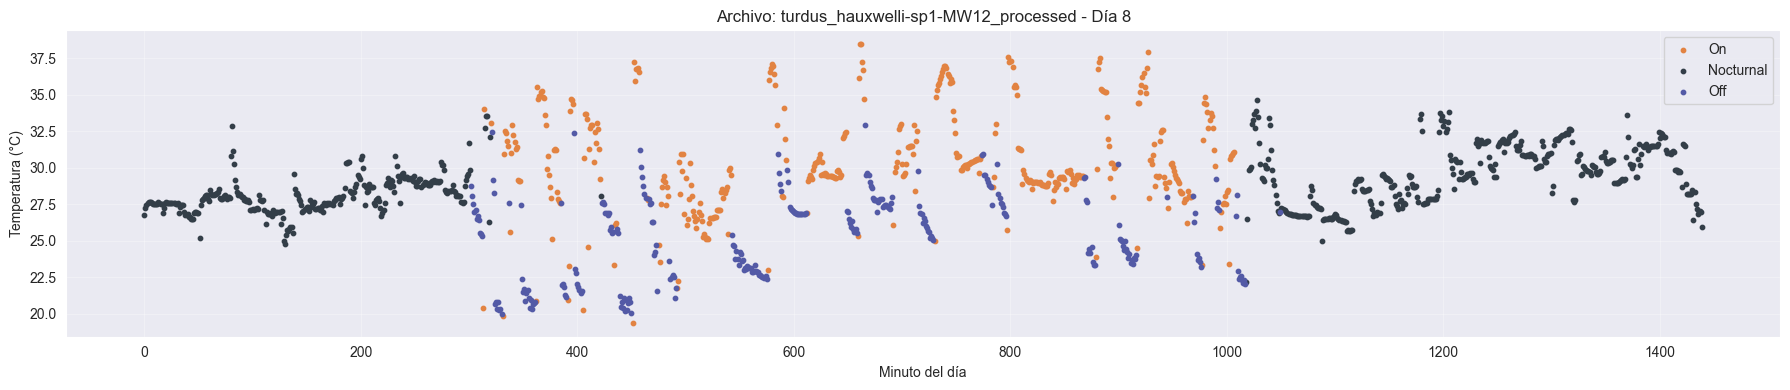

In [20]:
plot_prediccion_con_temperatura(df_resultados, datasets_combinados)

In [21]:
df_resultados

,archivo,dia,minuto,prediccion
0,Tangara_schrankii_P17a_MAL10_processed_soloegg,0,0,2
1,Tangara_schrankii_P17a_MAL10_processed_soloegg,0,1,2
2,Tangara_schrankii_P17a_MAL10_processed_soloegg,0,2,2
3,Tangara_schrankii_P17a_MAL10_processed_soloegg,0,3,2
4,Tangara_schrankii_P17a_MAL10_processed_soloegg,0,4,2
...,...,...,...,...
518395,Turdus__hauxwelli_SP5_GIO10_NEST_processed,4,1435,1
518396,Turdus__hauxwelli_SP5_GIO10_NEST_processed,4,1436,1
518397,Turdus__hauxwelli_SP5_GIO10_NEST_processed,4,1437,1
518398,Turdus__hauxwelli_SP5_GIO10_NEST_processed,4,1438,1


In [22]:
from scipy.stats import mode
import numpy as np

# Seleccion


In [23]:
import os

def exportar_graficas_por_dia(df_resultados, datasets_combinados, carpeta_out="G:/Thesis/figures/testing/tangara_2"):
    os.makedirs(carpeta_out, exist_ok=True)

    archivos_validos = df_resultados['archivo'].unique()

    for archivo_id in archivos_validos:
        dias_validos = df_resultados[df_resultados['archivo'] == archivo_id]['dia'].unique()

        for dia in sorted(dias_validos):
            df_plot = df_resultados[
                (df_resultados['archivo'] == archivo_id) &
                (df_resultados['dia'] == dia)
            ]

            if df_plot.empty or archivo_id not in datasets_combinados:
                continue

            df = datasets_combinados[archivo_id].copy()
            df.columns = [col.lower() for col in df.columns]
            df = df.rename(columns={'date-time': 'tiempo'} if 'date-time' in df.columns else {})

            if 'nest' in df.columns:
                df = df.rename(columns={'nest': 'egg'})

            fmt = formatos_por_archivo.get(archivo_id)
            df['tiempo'] = parsear_tiempo_con_formato(df, col='tiempo', fmt=fmt)
            df = df.dropna(subset=['tiempo'])
            df = df.sort_values('tiempo')
            df['tiempo_min'] = df['tiempo'].dt.hour * 60 + df['tiempo'].dt.minute

            start_idx = dia * 1440
            end_idx = start_idx + 1440
            if end_idx > len(df):
                continue

            df_day = df.iloc[start_idx:end_idx].copy().reset_index(drop=True)
            df_day['prediccion'] = df_plot.sort_values('minuto')['prediccion'].values

            colores = {0: '#333E48', 1: '#535AA6', 2: '#E28342'}
            etiquetas = {0: 'Nocturnal', 1: 'Off', 2: 'On'}

            fig, ax = plt.subplots(figsize=(18, 4))
            for clase in df_day['prediccion'].unique():
                mask = df_day['prediccion'] == clase
                ax.scatter(df_day.loc[mask, 'tiempo_min'], df_day.loc[mask, 'egg'],
                           color=colores[clase], label=etiquetas[clase], s=10)

            ax.set_title(f"{archivo_id} - Día {dia}")
            ax.set_xlabel("Minuto del día")
            ax.set_ylabel("Temperatura (°C)")
            ax.legend()
            ax.grid(alpha=0.3)
            fig.tight_layout()

            safe_name = f"{archivo_id}_DIA{dia}.png".replace("/", "_").replace("\\", "_")
            fig.savefig(os.path.join(carpeta_out, safe_name))
            plt.close(fig)

In [24]:
#exportar_graficas_por_dia(df_resultados, datasets_combinados)

In [25]:
# G:\Thesis\figures\testing\tangara_2\selected

In [26]:
from pathlib import Path

In [27]:
carpeta_filtrada = "G:/Thesis/figures/testing/tangara_2/selected"
archivos_ok = os.listdir(carpeta_filtrada)

# Extraer pares (archivo_id, dia) desde nombres como "Myioborus_minia_DIA3.png"
nombres_ok = []
for f in archivos_ok:
    if f.endswith(".png"):
        stem = Path(f).stem
        if "_DIA" in stem:
            archivo, dia = stem.rsplit("_DIA", 1)
            nombres_ok.append((archivo, int(dia)))

set_aceptados = set(nombres_ok)

# Filtrar resultados
df_filtrado = df_resultados[
    df_resultados.apply(lambda row: (row['archivo'], row['dia']) in set_aceptados, axis=1)
]

# Guardar como CSV
df_filtrado.to_csv("resultados_filtrados_2.csv", index=False)
print(f"✅ Exportado {len(df_filtrado)} filas a 'resultados_filtrados_2.csv'")

✅ Exportado 408960 filas a 'resultados_filtrados_2.csv'


In [28]:
filas_completas = []

for (archivo, dia), grupo in df_filtrado.groupby(['archivo', 'dia']):
    if archivo not in datasets_combinados:
        continue

    df_orig = datasets_combinados[archivo].copy()
    df_orig.columns = [col.lower() for col in df_orig.columns]
    df_orig = df_orig.rename(columns={'date-time': 'tiempo'} if 'date-time' in df_orig.columns else {})
    if 'nest' in df_orig.columns:
        df_orig = df_orig.rename(columns={'nest': 'egg'})

    df_orig['tiempo'] = pd.to_datetime(df_orig['tiempo'], errors='coerce')
    df_orig = df_orig.dropna(subset=['tiempo']).sort_values('tiempo')
    df_orig['tiempo_min'] = df_orig['tiempo'].dt.hour * 60 + df_orig['tiempo'].dt.minute

    start_idx = dia * 1440
    end_idx = start_idx + 1440

    if end_idx <= len(df_orig):
        df_day = df_orig.iloc[start_idx:end_idx].copy().reset_index(drop=True)
        df_preds = grupo.sort_values('minuto').reset_index(drop=True)

        # Concatenar columnas
        df_day = df_day.loc[:len(df_preds) - 1]  # recorte de seguridad
        df_preds = df_preds.loc[:len(df_day) - 1]

        df_day['archivo'] = archivo
        df_day['dia'] = dia
        df_day['minuto'] = df_preds['minuto']
        df_day['prediccion'] = df_preds['prediccion']

        filas_completas.append(df_day)

# Combinar todos los días aceptados en un solo DataFrame completo
df_filtrado_completo = pd.concat(filas_completas, ignore_index=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5424\439348587.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orig['tiempo'] = pd.to_datetime(df_orig['tiempo'], errors='coerce')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5424\439348587.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orig['tiempo'] = pd.to_datetime(df_orig['tiempo'], errors='coerce')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5424\439348587.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orig['tiempo'] = pd.to_datetime(df_orig['tiempo'], errors='coerce')
C:\Users\ASUS\AppData\Local\Temp\i

In [29]:
df_filtrado_completo

,#,tiempo,egg,ambient,tiempo_min,archivo,dia,minuto,prediccion
0,2,2013-09-11 14:48:57,27.087,27.481,888,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,0,2
1,3,2013-09-11 14:49:57,27.014,26.793,889,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,1,2
2,4,2013-09-11 14:50:57,27.038,26.891,890,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,2,2
3,5,2013-09-11 14:51:57,27.653,27.235,891,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,3,2
4,6,2013-09-11 14:52:57,27.628,26.940,892,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,4,2
...,...,...,...,...,...,...,...,...,...
408955,18717,2012-11-21 06:56:00,39.943,18.010,416,turdus_hauxwelli-sp1-MW12_processed,12,1435,0
408956,18718,2012-11-21 06:57:00,41.531,17.986,417,turdus_hauxwelli-sp1-MW12_processed,12,1436,0
408957,18719,2012-11-21 06:58:00,42.386,18.057,418,turdus_hauxwelli-sp1-MW12_processed,12,1437,0
408958,18720,2012-11-21 06:59:00,43.404,18.247,419,turdus_hauxwelli-sp1-MW12_processed,12,1438,0


In [30]:
def graficar_dia_aleatorio(df_filtrado_completo):
    archivo = random.choice(df_filtrado_completo['archivo'].unique())
    dias = df_filtrado_completo[df_filtrado_completo['archivo'] == archivo]['dia'].unique()
    dia = random.choice(dias)

    df_dia = df_filtrado_completo[
        (df_filtrado_completo['archivo'] == archivo) &
        (df_filtrado_completo['dia'] == dia)
    ].sort_values('tiempo_min')  # 🚨 ordenar por tiempo real

    colores = {0: '#333E48', 1: '#535AA6', 2: '#E28342'}
    etiquetas = {0: 'Nocturnal', 1: 'Off', 2: 'On'}



    plt.figure(figsize=(18, 5))

    # Línea de fondo de temperatura
    plt.plot(df_dia['tiempo_min'], df_dia['egg'], color='black', alpha=0.3, label='Nest Temp')
    plt.plot(df_dia['tiempo_min'], df_dia['ambient'], color='gray', alpha=0.3, label='Ambient Temp')

    for clase in df_dia['prediccion'].unique():
        mask = df_dia['prediccion'] == clase
        plt.scatter(df_dia.loc[mask, 'tiempo_min'], df_dia.loc[mask, 'egg'],
                    color=colores[clase], label=etiquetas[clase], s=10)

    plt.title(f"{archivo} - Día {dia}")
    plt.xlabel("Minuto del día (desde medianoche)")
    plt.ylabel("Temperatura (°C)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

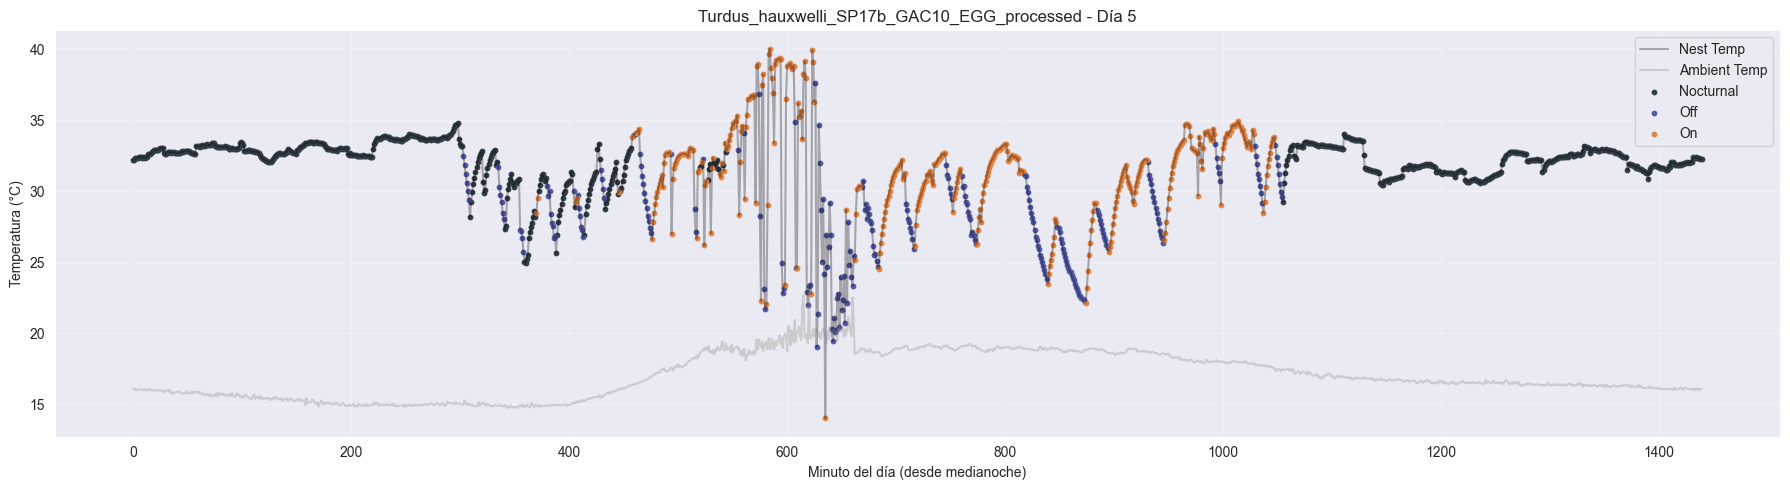

In [31]:
graficar_dia_aleatorio(df_filtrado_completo)

In [32]:
def calcular_estadisticas_generales(grupo):
    return pd.Series({
        'archivo': grupo['archivo'].iloc[0],
        'dia': grupo['dia'].iloc[0],
        'total_on': (grupo['prediccion'] == 2).sum(),
        'total_off': (grupo['prediccion'] == 1).sum(),
        'total_nocturnal': (grupo['prediccion'] == 0).sum(),
        'avg_ambient': grupo['ambient'].mean(),
        'std_ambient': grupo['ambient'].std()
    })


In [33]:
estadisticas_df = df_filtrado_completo.groupby(['archivo', 'dia']).apply(calcular_estadisticas_generales).reset_index(drop=True)
estadisticas_df.to_csv("estadisticas_generales.csv", index=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5424\2088123188.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estadisticas_df = df_filtrado_completo.groupby(['archivo', 'dia']).apply(calcular_estadisticas_generales).reset_index(drop=True)


In [34]:
print(estadisticas_df.head())

                                        archivo  dia  total_on  total_off  \
0  Myrmotherula_hauxwelli_P02a_AJRC13_processed    0       296        728   
1  Myrmotherula_hauxwelli_P02a_AJRC13_processed    1       172        514   
2  Myrmotherula_hauxwelli_P02a_AJRC13_processed    2       149        443   
3  Myrmotherula_hauxwelli_P02a_AJRC13_processed    3       234        336   
4  Myrmotherula_hauxwelli_P02a_AJRC13_processed    4       309        609   

   total_nocturnal  avg_ambient  std_ambient  
0              416    24.100521     2.079191  
1              754    24.383801     2.003638  
2              848    22.901703     1.204762  
3              870    22.000955     1.538040  
4              522    24.185844     1.489912  


In [35]:
def obtener_tipo_sensor(nombre_archivo):
    nombre = nombre_archivo.lower()
    return 'egg' if '_soloegg' in nombre else 'nest'

def extraer_eventos_por_grupo(grupo):
    eventos = []
    evento_id_counter = {'On': 0, 'Off': 0, 'Nocturnal': 0}
    estado_map = {2: 'On', 1: 'Off', 0: 'Nocturnal'}
    archivo_actual = grupo['archivo'].iloc[0]
    sensor = obtener_tipo_sensor(archivo_actual)
    evento_num_total = 1

    i_inicio = 0
    for i in range(1, len(grupo)):
        actual = grupo['prediccion'].iloc[i]
        previo = grupo['prediccion'].iloc[i - 1]

        if actual != previo:
            i_fin = i - 1
            segmento = grupo.iloc[i_inicio:i_fin + 1]
            inicio = segmento.iloc[0]
            fin = segmento.iloc[-1]
            duracion = fin['minuto'] - inicio['minuto'] + 1

            ambient_values = segmento['ambient'].values
            sensor_values = segmento['egg'].values

            # Inicializar campos
            min_temp_off = np.nan
            avg_temp_off = np.nan
            avg_temp_on = np.nan
            avg_ambient_temp_on = np.nan
            avg_temp_nocturnal = np.nan
            avg_ambient_temp_nocturnal = np.nan

            estado_str = estado_map.get(previo, 'Unknown')

            # Reclasificación
            if estado_str == 'Nocturnal' and duracion < 100:
                estado_str = 'On'
                evento_id_counter['On'] += 1
                evento_id_str = f"On_{evento_id_counter['On']}"
                avg_temp_on = np.mean(sensor_values)
                avg_ambient_temp_on = np.mean(ambient_values)
            else:
                evento_id_counter[estado_str] += 1
                evento_id_str = f"{estado_str}_{evento_id_counter[estado_str]}"
                if estado_str == 'Off':
                    min_temp_off = np.min(ambient_values)
                    avg_temp_off = np.mean(sensor_values)
                elif estado_str == 'On':
                    avg_temp_on = np.mean(sensor_values)
                    avg_ambient_temp_on = np.mean(ambient_values)
                elif estado_str == 'Nocturnal':
                    avg_temp_nocturnal = np.mean(sensor_values)
                    avg_ambient_temp_nocturnal = np.mean(ambient_values)

            eventos.append({
                'archivo': inicio['archivo'],
                'dia': inicio['dia'],
                'evento_id': evento_id_str,
                'evento_num': evento_num_total,
                'estado': estado_str,
                'minuto_inicio': inicio['minuto'],
                'minuto_fin': fin['minuto'],
                'tiempo_inicio': inicio['tiempo'],
                'tiempo_fin': fin['tiempo'],
                'duracion_min': duracion,
                'sensor': sensor,
                'min_temp_off': min_temp_off,
                'avg_temp_off': avg_temp_off,
                'avg_temp_on': avg_temp_on,
                'avg_ambient_temp_on': avg_ambient_temp_on,
                'avg_temp_nocturnal': avg_temp_nocturnal,
                'avg_ambient_temp_nocturnal': avg_ambient_temp_nocturnal
            })
            evento_num_total += 1
            i_inicio = i

    # Último segmento
    segmento = grupo.iloc[i_inicio:]
    inicio = segmento.iloc[0]
    fin = segmento.iloc[-1]
    duracion = fin['minuto'] - inicio['minuto'] + 1

    ambient_values = segmento['ambient'].values
    sensor_values = segmento['egg'].values

    min_temp_off = np.nan
    avg_temp_off = np.nan
    avg_temp_on = np.nan
    avg_ambient_temp_on = np.nan
    avg_temp_nocturnal = np.nan
    avg_ambient_temp_nocturnal = np.nan

    estado_str = estado_map.get(grupo['prediccion'].iloc[-1], 'Unknown')

    if estado_str == 'Nocturnal' and duracion < 100:
        estado_str = 'On'
        evento_id_counter['On'] += 1
        evento_id_str = f"On_{evento_id_counter['On']}"
        avg_temp_on = np.mean(sensor_values)
        avg_ambient_temp_on = np.mean(ambient_values)
    else:
        evento_id_counter[estado_str] += 1
        evento_id_str = f"{estado_str}_{evento_id_counter[estado_str]}"
        if estado_str == 'Off':
            min_temp_off = np.min(ambient_values)
            avg_temp_off = np.mean(sensor_values)
        elif estado_str == 'On':
            avg_temp_on = np.mean(sensor_values)
            avg_ambient_temp_on = np.mean(ambient_values)
        elif estado_str == 'Nocturnal':
            avg_temp_nocturnal = np.mean(sensor_values)
            avg_ambient_temp_nocturnal = np.mean(ambient_values)

    eventos.append({
        'archivo': inicio['archivo'],
        'dia': inicio['dia'],
        'evento_id': evento_id_str,
        'evento_num': evento_num_total,
        'estado': estado_str,
        'minuto_inicio': inicio['minuto'],
        'minuto_fin': fin['minuto'],
        'tiempo_inicio': inicio['tiempo'],
        'tiempo_fin': fin['tiempo'],
        'duracion_min': duracion,
        'sensor': sensor,
        'min_temp_off': min_temp_off,
        'avg_temp_off': avg_temp_off,
        'avg_temp_on': avg_temp_on,
        'avg_ambient_temp_on': avg_ambient_temp_on,
        'avg_temp_nocturnal': avg_temp_nocturnal,
        'avg_ambient_temp_nocturnal': avg_ambient_temp_nocturnal
    })

    return eventos

In [36]:
df_filtrado_completo['tiempo'] = pd.to_datetime(df_filtrado_completo['tiempo'])

todos_los_eventos = []
for (archivo, dia), grupo in df_filtrado_completo.groupby(['archivo', 'dia']):
    grupo_ordenado = grupo.sort_values('minuto')
    eventos = extraer_eventos_por_grupo(grupo_ordenado)
    todos_los_eventos.extend(eventos)

eventos_df = pd.DataFrame(todos_los_eventos)


In [37]:
eventos_df

,archivo,dia,evento_id,evento_num,estado,minuto_inicio,minuto_fin,tiempo_inicio,tiempo_fin,duracion_min,sensor,min_temp_off,avg_temp_off,avg_temp_on,avg_ambient_temp_on,avg_temp_nocturnal,avg_ambient_temp_nocturnal
0,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,On_1,1,On,0,12,2013-09-11 14:48:57,2013-09-11 15:00:57,13,nest,NaN,NaN,27.399308,26.944231,NaN,NaN
1,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,Off_1,2,Off,13,42,2013-09-11 15:01:57,2013-09-11 15:30:57,30,nest,26.061,26.892967,NaN,NaN,NaN,NaN
2,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,On_2,3,On,43,82,2013-09-11 15:31:57,2013-09-11 16:10:57,40,nest,NaN,NaN,29.774400,25.942475,NaN,NaN
3,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,Off_2,4,Off,83,156,2013-09-11 16:11:57,2013-09-11 17:24:57,74,nest,25.040,27.031122,NaN,NaN,NaN,NaN
4,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,Nocturnal_1,5,Nocturnal,157,286,2013-09-11 17:25:57,2013-09-11 19:34:57,130,nest,NaN,NaN,NaN,NaN,32.631062,23.824285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7979,turdus_hauxwelli-sp1-MW12_processed,12,Nocturnal_1,39,Nocturnal,690,1376,2012-11-20 18:31:00,2012-11-21 05:57:00,687,nest,NaN,NaN,NaN,NaN,41.676087,17.989504
7980,turdus_hauxwelli-sp1-MW12_processed,12,Off_20,40,Off,1377,1378,2012-11-21 05:58:00,2012-11-21 05:59:00,2,nest,17.510,39.431500,NaN,NaN,NaN,NaN
7981,turdus_hauxwelli-sp1-MW12_processed,12,On_20,41,On,1379,1414,2012-11-21 06:00:00,2012-11-21 06:35:00,36,nest,NaN,NaN,41.606028,17.607417,NaN,NaN
7982,turdus_hauxwelli-sp1-MW12_processed,12,Off_21,42,Off,1415,1425,2012-11-21 06:36:00,2012-11-21 06:46:00,11,nest,17.748,40.581000,NaN,NaN,NaN,NaN


In [38]:
print(eventos_df.columns)


Index(['archivo', 'dia', 'evento_id', 'evento_num', 'estado', 'minuto_inicio',
       'minuto_fin', 'tiempo_inicio', 'tiempo_fin', 'duracion_min', 'sensor',
       'min_temp_off', 'avg_temp_off', 'avg_temp_on', 'avg_ambient_temp_on',
       'avg_temp_nocturnal', 'avg_ambient_temp_nocturnal'],
      dtype='object')


In [39]:
# 1. Crear columna auxiliar con el ID base del nido (quitando "_soloegg" y "_processed")
eventos_df['nido_id'] = eventos_df['archivo'].str.replace('_soloegg', '', regex=False).str.replace('_processed', '', regex=False)

# 2. Separar en dos datasets por tipo de sensor
egg_df = eventos_df[eventos_df['sensor'] == 'egg']
nest_df = eventos_df[eventos_df['sensor'] == 'nest']

# 3. Identificar los nido_id que tienen versión tipo "egg"
nidos_con_egg = set(egg_df['nido_id'].unique())

# 4. Filtrar los nidos (sensor nest) que NO tienen equivalente en egg
nest_sin_egg_df = nest_df[~nest_df['nido_id'].isin(nidos_con_egg)]

# 5. Unir los dos subconjuntos: todos los de huevo y los nidos que no están duplicados
eventos_filtrados = pd.concat([egg_df, nest_sin_egg_df], ignore_index=True)

# (opcional) eliminar la columna auxiliar
eventos_filtrados = eventos_filtrados.drop(columns=['nido_id'])

In [40]:
eventos_filtrados

,archivo,dia,evento_id,evento_num,estado,minuto_inicio,minuto_fin,tiempo_inicio,tiempo_fin,duracion_min,sensor,min_temp_off,avg_temp_off,avg_temp_on,avg_ambient_temp_on,avg_temp_nocturnal,avg_ambient_temp_nocturnal
0,Tangara_schranki_T1b_GVC_08_processed_soloegg,0,On_1,1,On,0,4,2008-10-18 14:31:00,2008-10-18 14:35:00,5,egg,NaN,NaN,45.598400,64.172000,NaN,NaN
1,Tangara_schranki_T1b_GVC_08_processed_soloegg,0,Off_1,2,Off,5,19,2008-10-18 14:36:00,2008-10-18 14:50:00,15,egg,22.441,30.350733,NaN,NaN,NaN,NaN
2,Tangara_schranki_T1b_GVC_08_processed_soloegg,0,On_2,3,On,20,104,2008-10-18 14:51:00,2008-10-18 16:15:00,85,egg,NaN,NaN,35.868812,22.484518,NaN,NaN
3,Tangara_schranki_T1b_GVC_08_processed_soloegg,0,Off_2,4,Off,105,125,2008-10-18 16:16:00,2008-10-18 16:36:00,21,egg,22.058,32.282619,NaN,NaN,NaN,NaN
4,Tangara_schranki_T1b_GVC_08_processed_soloegg,0,Nocturnal_1,5,Nocturnal,126,886,2008-10-18 16:37:00,2008-10-19 05:17:00,761,egg,NaN,NaN,NaN,NaN,33.715552,20.273318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6934,turdus_hauxwelli-sp1-MW12_processed,12,Nocturnal_1,39,Nocturnal,690,1376,2012-11-20 18:31:00,2012-11-21 05:57:00,687,nest,NaN,NaN,NaN,NaN,41.676087,17.989504
6935,turdus_hauxwelli-sp1-MW12_processed,12,Off_20,40,Off,1377,1378,2012-11-21 05:58:00,2012-11-21 05:59:00,2,nest,17.510,39.431500,NaN,NaN,NaN,NaN
6936,turdus_hauxwelli-sp1-MW12_processed,12,On_20,41,On,1379,1414,2012-11-21 06:00:00,2012-11-21 06:35:00,36,nest,NaN,NaN,41.606028,17.607417,NaN,NaN
6937,turdus_hauxwelli-sp1-MW12_processed,12,Off_21,42,Off,1415,1425,2012-11-21 06:36:00,2012-11-21 06:46:00,11,nest,17.748,40.581000,NaN,NaN,NaN,NaN


In [41]:
def calcular_nest_attentiveness_diurna_con_estadisticas(df_eventos):
    resultados = []

    for (archivo, dia), grupo in df_eventos.groupby(['archivo', 'dia']):
        grupo = grupo.sort_values('minuto_inicio')
        grupo_off = grupo[grupo['estado'] == 'Off']
        grupo_on = grupo[grupo['estado'] == 'On']
        grupo_nocturnal = grupo[grupo['estado'] == 'Nocturnal']

        # Nest attentiveness solo si hay off y nocturnal
        if len(grupo_off) == 0 or len(grupo_nocturnal) == 0:
            resultados.append({
                'archivo': archivo,
                'dia': dia,
                'nest_attentiveness_day': np.nan,
                'duracion_total_on': np.nan,
                'duracion_intervalo_day': np.nan,
                'inicio_intervalo': np.nan,
                'fin_intervalo': np.nan,
                'avg_duracion_on': grupo_on['duracion_min'].mean() if len(grupo_on) > 0 else np.nan,
                'avg_duracion_off': grupo_off['duracion_min'].mean() if len(grupo_off) > 0 else np.nan,
                'avg_duracion_nocturnal': grupo_nocturnal['duracion_min'].mean() if len(grupo_nocturnal) > 0 else np.nan,
                'n_eventos_on': len(grupo_on),
                'n_eventos_off': len(grupo_off)
            })
            continue

        # Intervalo diurno: primer OFF hasta inicio del último NOCTURNAL
        inicio_intervalo = grupo_off['minuto_inicio'].iloc[0]
        fin_intervalo = grupo_nocturnal['minuto_inicio'].iloc[-1] - 1
        duracion_intervalo = fin_intervalo - inicio_intervalo + 1

        if duracion_intervalo <= 0:
            resultados.append({
                'archivo': archivo,
                'dia': dia,
                'nest_attentiveness_day': np.nan,
                'duracion_total_on': 0,
                'duracion_intervalo_day': duracion_intervalo,
                'inicio_intervalo': inicio_intervalo,
                'fin_intervalo': fin_intervalo,
                'avg_duracion_on': grupo_on['duracion_min'].mean() if len(grupo_on) > 0 else np.nan,
                'avg_duracion_off': grupo_off['duracion_min'].mean() if len(grupo_off) > 0 else np.nan,
                'avg_duracion_nocturnal': grupo_nocturnal['duracion_min'].mean() if len(grupo_nocturnal) > 0 else np.nan,
                'n_eventos_on': len(grupo_on),
                'n_eventos_off': len(grupo_off)
            })
            continue

        grupo_on_filtrado = grupo_on[
            (grupo_on['minuto_inicio'] >= inicio_intervalo) &
            (grupo_on['minuto_fin'] <= fin_intervalo)
        ]

        duracion_total_on = grupo_on_filtrado['duracion_min'].sum()
        nest_attentiveness = duracion_total_on / duracion_intervalo

        resultados.append({
            'archivo': archivo,
            'dia': dia,
            'nest_attentiveness_day': nest_attentiveness,
            'duracion_total_on': duracion_total_on,
            'duracion_intervalo_day': duracion_intervalo,
            'inicio_intervalo': inicio_intervalo,
            'fin_intervalo': fin_intervalo,
            'avg_duracion_on': grupo_on['duracion_min'].mean() if len(grupo_on) > 0 else np.nan,
            'avg_duracion_off': grupo_off['duracion_min'].mean() if len(grupo_off) > 0 else np.nan,
            'avg_duracion_nocturnal': grupo_nocturnal['duracion_min'].mean() if len(grupo_nocturnal) > 0 else np.nan,
            'n_eventos_on': len(grupo_on),
            'n_eventos_off': len(grupo_off)
        })

    return pd.DataFrame(resultados)

In [42]:
nest_attentiveness_day_df = calcular_nest_attentiveness_diurna_con_estadisticas(eventos_filtrados)


In [43]:
nest_attentiveness_day_df

,archivo,dia,nest_attentiveness_day,duracion_total_on,duracion_intervalo_day,inicio_intervalo,fin_intervalo,avg_duracion_on,avg_duracion_off,avg_duracion_nocturnal,n_eventos_on,n_eventos_off
0,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,0.070376,43.0,611.0,13.0,623.0,37.375000,72.800000,206.5,8,10
1,Myrmotherula_hauxwelli_P02a_AJRC13_processed,1,0.269737,41.0,152.0,6.0,157.0,24.714286,73.428571,753.0,7,7
2,Myrmotherula_hauxwelli_P02a_AJRC13_processed,2,0.000000,0.0,168.0,0.0,167.0,81.000000,110.750000,754.0,3,4
3,Myrmotherula_hauxwelli_P02a_AJRC13_processed,3,0.152359,197.0,1293.0,37.0,1329.0,58.500000,67.200000,435.0,4,5
4,Myrmotherula_hauxwelli_P02a_AJRC13_processed,4,0.376812,52.0,138.0,14.0,151.0,44.285714,87.000000,521.0,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...
250,turdus_hauxwelli-sp1-MW12_processed,8,0.641148,402.0,627.0,2.0,628.0,16.310345,10.576923,692.0,29,26
251,turdus_hauxwelli-sp1-MW12_processed,9,0.644940,376.0,583.0,17.0,599.0,11.000000,8.454545,721.0,40,33
252,turdus_hauxwelli-sp1-MW12_processed,10,0.677049,413.0,610.0,6.0,615.0,12.972973,8.093750,701.0,37,32
253,turdus_hauxwelli-sp1-MW12_processed,11,0.718553,457.0,636.0,32.0,667.0,14.974359,5.105263,662.0,39,38


In [44]:
promedios_ambient = df_filtrado_completo.groupby(['archivo', 'dia'])['ambient'].mean().reset_index()
promedios_ambient = promedios_ambient.rename(columns={'ambient': 'avg_temp_ambient_diaria'})

In [45]:
# Unir por archivo y dia
nest_attentiveness_day_df = nest_attentiveness_day_df.merge(
    promedios_ambient,
    on=['archivo', 'dia'],
    how='left'
)

In [46]:
nest_attentiveness_day_df

,archivo,dia,nest_attentiveness_day,duracion_total_on,duracion_intervalo_day,inicio_intervalo,fin_intervalo,avg_duracion_on,avg_duracion_off,avg_duracion_nocturnal,n_eventos_on,n_eventos_off,avg_temp_ambient_diaria
0,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,0.070376,43.0,611.0,13.0,623.0,37.375000,72.800000,206.5,8,10,24.100521
1,Myrmotherula_hauxwelli_P02a_AJRC13_processed,1,0.269737,41.0,152.0,6.0,157.0,24.714286,73.428571,753.0,7,7,24.383801
2,Myrmotherula_hauxwelli_P02a_AJRC13_processed,2,0.000000,0.0,168.0,0.0,167.0,81.000000,110.750000,754.0,3,4,22.901703
3,Myrmotherula_hauxwelli_P02a_AJRC13_processed,3,0.152359,197.0,1293.0,37.0,1329.0,58.500000,67.200000,435.0,4,5,22.000955
4,Myrmotherula_hauxwelli_P02a_AJRC13_processed,4,0.376812,52.0,138.0,14.0,151.0,44.285714,87.000000,521.0,7,7,24.185844
...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,turdus_hauxwelli-sp1-MW12_processed,8,0.641148,402.0,627.0,2.0,628.0,16.310345,10.576923,692.0,29,26,19.296140
251,turdus_hauxwelli-sp1-MW12_processed,9,0.644940,376.0,583.0,17.0,599.0,11.000000,8.454545,721.0,40,33,18.534195
252,turdus_hauxwelli-sp1-MW12_processed,10,0.677049,413.0,610.0,6.0,615.0,12.972973,8.093750,701.0,37,32,18.431207
253,turdus_hauxwelli-sp1-MW12_processed,11,0.718553,457.0,636.0,32.0,667.0,14.974359,5.105263,662.0,39,38,19.426871


In [47]:
nest_attentiveness_day_df = nest_attentiveness_day_df.dropna(subset=['nest_attentiveness_day']).reset_index(drop=True)

In [48]:
nest_attentiveness_day_df = nest_attentiveness_day_df[
    (nest_attentiveness_day_df['nest_attentiveness_day'].notna()) &
    (nest_attentiveness_day_df['nest_attentiveness_day'] > 0)
].reset_index(drop=True)

In [49]:
nest_attentiveness_day_df

,archivo,dia,nest_attentiveness_day,duracion_total_on,duracion_intervalo_day,inicio_intervalo,fin_intervalo,avg_duracion_on,avg_duracion_off,avg_duracion_nocturnal,n_eventos_on,n_eventos_off,avg_temp_ambient_diaria
0,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,0.070376,43.0,611.0,13.0,623.0,37.375000,72.800000,206.5,8,10,24.100521
1,Myrmotherula_hauxwelli_P02a_AJRC13_processed,1,0.269737,41.0,152.0,6.0,157.0,24.714286,73.428571,753.0,7,7,24.383801
2,Myrmotherula_hauxwelli_P02a_AJRC13_processed,3,0.152359,197.0,1293.0,37.0,1329.0,58.500000,67.200000,435.0,4,5,22.000955
3,Myrmotherula_hauxwelli_P02a_AJRC13_processed,4,0.376812,52.0,138.0,14.0,151.0,44.285714,87.000000,521.0,7,7,24.185844
4,Myrmotherula_hauxwelli_P02a_AJRC13_processed,5,0.495238,52.0,105.0,37.0,141.0,67.000000,33.285714,805.0,6,7,24.988724
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,turdus_hauxwelli-sp1-MW12_processed,8,0.641148,402.0,627.0,2.0,628.0,16.310345,10.576923,692.0,29,26,19.296140
194,turdus_hauxwelli-sp1-MW12_processed,9,0.644940,376.0,583.0,17.0,599.0,11.000000,8.454545,721.0,40,33,18.534195
195,turdus_hauxwelli-sp1-MW12_processed,10,0.677049,413.0,610.0,6.0,615.0,12.972973,8.093750,701.0,37,32,18.431207
196,turdus_hauxwelli-sp1-MW12_processed,11,0.718553,457.0,636.0,32.0,667.0,14.974359,5.105263,662.0,39,38,19.426871


In [50]:
import re

In [51]:
# Hacer una copia
resumen_copy = nest_attentiveness_day_df.copy()

def _tokens(nombre_archivo: str):
    base = os.path.splitext(os.path.basename(nombre_archivo))[0]
    # divide por uno o más _ o -, y elimina vacíos
    toks = [t for t in re.split(r'[_\-]+', base) if t]
    return toks

def extraer_especie(nombre_archivo: str):
    toks = _tokens(nombre_archivo)
    # primeras dos palabras alfabéticas -> Género especie
    letras = [t for t in toks if re.fullmatch(r'[A-Za-z]+', t)]
    if len(letras) >= 2:
        genero = letras[0].capitalize()
        especie = letras[1].lower()
        return f"{genero} {especie}"
    return np.nan

def extraer_id_nido(nombre_archivo: str):
    toks = _tokens(nombre_archivo)
    # los dos tokens después del género y especie (posición 2 y 3)
    if len(toks) >= 3:
        return "_".join(toks[2:4])  # p.ej. SP5_GIO10, P02a_AJRC13, etc.
    return np.nan

resumen_copy = nest_attentiveness_day_df.copy()
resumen_copy['especie'] = resumen_copy['archivo'].apply(extraer_especie)
resumen_copy['nido_id'] = resumen_copy['archivo'].apply(extraer_id_nido)

In [52]:
resumen_copy

,archivo,dia,nest_attentiveness_day,duracion_total_on,duracion_intervalo_day,inicio_intervalo,fin_intervalo,avg_duracion_on,avg_duracion_off,avg_duracion_nocturnal,n_eventos_on,n_eventos_off,avg_temp_ambient_diaria,especie,nido_id
0,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,0.070376,43.0,611.0,13.0,623.0,37.375000,72.800000,206.5,8,10,24.100521,Myrmotherula hauxwelli,P02a_AJRC13
1,Myrmotherula_hauxwelli_P02a_AJRC13_processed,1,0.269737,41.0,152.0,6.0,157.0,24.714286,73.428571,753.0,7,7,24.383801,Myrmotherula hauxwelli,P02a_AJRC13
2,Myrmotherula_hauxwelli_P02a_AJRC13_processed,3,0.152359,197.0,1293.0,37.0,1329.0,58.500000,67.200000,435.0,4,5,22.000955,Myrmotherula hauxwelli,P02a_AJRC13
3,Myrmotherula_hauxwelli_P02a_AJRC13_processed,4,0.376812,52.0,138.0,14.0,151.0,44.285714,87.000000,521.0,7,7,24.185844,Myrmotherula hauxwelli,P02a_AJRC13
4,Myrmotherula_hauxwelli_P02a_AJRC13_processed,5,0.495238,52.0,105.0,37.0,141.0,67.000000,33.285714,805.0,6,7,24.988724,Myrmotherula hauxwelli,P02a_AJRC13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,turdus_hauxwelli-sp1-MW12_processed,8,0.641148,402.0,627.0,2.0,628.0,16.310345,10.576923,692.0,29,26,19.296140,Turdus hauxwelli,sp1_MW12
194,turdus_hauxwelli-sp1-MW12_processed,9,0.644940,376.0,583.0,17.0,599.0,11.000000,8.454545,721.0,40,33,18.534195,Turdus hauxwelli,sp1_MW12
195,turdus_hauxwelli-sp1-MW12_processed,10,0.677049,413.0,610.0,6.0,615.0,12.972973,8.093750,701.0,37,32,18.431207,Turdus hauxwelli,sp1_MW12
196,turdus_hauxwelli-sp1-MW12_processed,11,0.718553,457.0,636.0,32.0,667.0,14.974359,5.105263,662.0,39,38,19.426871,Turdus hauxwelli,sp1_MW12


In [53]:
#especies_unicas = resumen_copy['especie'].dropna().unique()
#df_especies = pd.DataFrame(especies_unicas, columns=['especie'])
#df_especies.to_csv("especies_unicas.csv", index=False)

In [54]:
df_especies = pd.read_csv('G:/Thesis/BoutScout_Model/especies_unicas_new.csv')
mapa_especies = dict(zip(df_especies['especie'], df_especies['n_sp']))

In [55]:
resumen_copy['sp'] = resumen_copy['especie'].map(mapa_especies)

In [56]:
resumen_copy

,archivo,dia,nest_attentiveness_day,duracion_total_on,duracion_intervalo_day,inicio_intervalo,fin_intervalo,avg_duracion_on,avg_duracion_off,avg_duracion_nocturnal,n_eventos_on,n_eventos_off,avg_temp_ambient_diaria,especie,nido_id,sp
0,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,0.070376,43.0,611.0,13.0,623.0,37.375000,72.800000,206.5,8,10,24.100521,Myrmotherula hauxwelli,P02a_AJRC13,Isleria hauxwelli
1,Myrmotherula_hauxwelli_P02a_AJRC13_processed,1,0.269737,41.0,152.0,6.0,157.0,24.714286,73.428571,753.0,7,7,24.383801,Myrmotherula hauxwelli,P02a_AJRC13,Isleria hauxwelli
2,Myrmotherula_hauxwelli_P02a_AJRC13_processed,3,0.152359,197.0,1293.0,37.0,1329.0,58.500000,67.200000,435.0,4,5,22.000955,Myrmotherula hauxwelli,P02a_AJRC13,Isleria hauxwelli
3,Myrmotherula_hauxwelli_P02a_AJRC13_processed,4,0.376812,52.0,138.0,14.0,151.0,44.285714,87.000000,521.0,7,7,24.185844,Myrmotherula hauxwelli,P02a_AJRC13,Isleria hauxwelli
4,Myrmotherula_hauxwelli_P02a_AJRC13_processed,5,0.495238,52.0,105.0,37.0,141.0,67.000000,33.285714,805.0,6,7,24.988724,Myrmotherula hauxwelli,P02a_AJRC13,Isleria hauxwelli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,turdus_hauxwelli-sp1-MW12_processed,8,0.641148,402.0,627.0,2.0,628.0,16.310345,10.576923,692.0,29,26,19.296140,Turdus hauxwelli,sp1_MW12,Turdus hauxwelli
194,turdus_hauxwelli-sp1-MW12_processed,9,0.644940,376.0,583.0,17.0,599.0,11.000000,8.454545,721.0,40,33,18.534195,Turdus hauxwelli,sp1_MW12,Turdus hauxwelli
195,turdus_hauxwelli-sp1-MW12_processed,10,0.677049,413.0,610.0,6.0,615.0,12.972973,8.093750,701.0,37,32,18.431207,Turdus hauxwelli,sp1_MW12,Turdus hauxwelli
196,turdus_hauxwelli-sp1-MW12_processed,11,0.718553,457.0,636.0,32.0,667.0,14.974359,5.105263,662.0,39,38,19.426871,Turdus hauxwelli,sp1_MW12,Turdus hauxwelli


In [57]:
#df_unicos = resumen_copy[['archivo', 'especie', 'nido_id', 'sp']].drop_duplicates()
#df_unicos.to_csv("G:/Thesis/BoutScout_Model/unicos_archivo_especie_nido_sp.csv", index=False)

base_tangara = pd.read_csv("G:/Thesis/BoutScout_Model/Base_tangara.csv")
base_equiv = pd.read_csv("G:/Thesis/BoutScout_Model/unicos_archivo_especie_nido_sp_anadir.csv")


In [58]:
resumen_copy = resumen_copy.merge(
    base_equiv[['archivo', 'sp_old', 'cod_del_nido']],
    on="archivo",
    how="left"
)

In [59]:
resumen_copy = resumen_copy.merge(
    base_tangara[['Especie', 'Numero_del_Nido', 'Elevacion', 'Largo_mm.2', 'Ancho_mm.2', 'Peso_g']],
    left_on=['sp_old', 'cod_del_nido'],
    right_on=['Especie', 'Numero_del_Nido'],
    how="left"
)

In [60]:
resumen_copy = resumen_copy.drop(columns=['Especie', 'Numero_del_Nido'])

In [61]:
resumen_copy

,archivo,dia,nest_attentiveness_day,duracion_total_on,duracion_intervalo_day,inicio_intervalo,fin_intervalo,avg_duracion_on,avg_duracion_off,avg_duracion_nocturnal,...,avg_temp_ambient_diaria,especie,nido_id,sp,sp_old,cod_del_nido,Elevacion,Largo_mm.2,Ancho_mm.2,Peso_g
0,Myrmotherula_hauxwelli_P02a_AJRC13_processed,0,0.070376,43.0,611.0,13.0,623.0,37.375000,72.800000,206.5,...,24.100521,Myrmotherula hauxwelli,P02a_AJRC13,Isleria hauxwelli,Isleria_hauxwelli,P02_AJRC13,400.0,17.1,12.7,1.70
1,Myrmotherula_hauxwelli_P02a_AJRC13_processed,1,0.269737,41.0,152.0,6.0,157.0,24.714286,73.428571,753.0,...,24.383801,Myrmotherula hauxwelli,P02a_AJRC13,Isleria hauxwelli,Isleria_hauxwelli,P02_AJRC13,400.0,17.1,12.7,1.70
2,Myrmotherula_hauxwelli_P02a_AJRC13_processed,3,0.152359,197.0,1293.0,37.0,1329.0,58.500000,67.200000,435.0,...,22.000955,Myrmotherula hauxwelli,P02a_AJRC13,Isleria hauxwelli,Isleria_hauxwelli,P02_AJRC13,400.0,17.1,12.7,1.70
3,Myrmotherula_hauxwelli_P02a_AJRC13_processed,4,0.376812,52.0,138.0,14.0,151.0,44.285714,87.000000,521.0,...,24.185844,Myrmotherula hauxwelli,P02a_AJRC13,Isleria hauxwelli,Isleria_hauxwelli,P02_AJRC13,400.0,17.1,12.7,1.70
4,Myrmotherula_hauxwelli_P02a_AJRC13_processed,5,0.495238,52.0,105.0,37.0,141.0,67.000000,33.285714,805.0,...,24.988724,Myrmotherula hauxwelli,P02a_AJRC13,Isleria hauxwelli,Isleria_hauxwelli,P02_AJRC13,400.0,17.1,12.7,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,turdus_hauxwelli-sp1-MW12_processed,8,0.641148,402.0,627.0,2.0,628.0,16.310345,10.576923,692.0,...,19.296140,Turdus hauxwelli,sp1_MW12,Turdus hauxwelli,Turdus_hauxwelli,SP1_MW12,1266.0,25,20,5.72
194,turdus_hauxwelli-sp1-MW12_processed,9,0.644940,376.0,583.0,17.0,599.0,11.000000,8.454545,721.0,...,18.534195,Turdus hauxwelli,sp1_MW12,Turdus hauxwelli,Turdus_hauxwelli,SP1_MW12,1266.0,25,20,5.72
195,turdus_hauxwelli-sp1-MW12_processed,10,0.677049,413.0,610.0,6.0,615.0,12.972973,8.093750,701.0,...,18.431207,Turdus hauxwelli,sp1_MW12,Turdus hauxwelli,Turdus_hauxwelli,SP1_MW12,1266.0,25,20,5.72
196,turdus_hauxwelli-sp1-MW12_processed,11,0.718553,457.0,636.0,32.0,667.0,14.974359,5.105263,662.0,...,19.426871,Turdus hauxwelli,sp1_MW12,Turdus hauxwelli,Turdus_hauxwelli,SP1_MW12,1266.0,25,20,5.72


In [62]:
#resumen_copy['sp'].unique()

In [63]:
mass_dict = {
    'Isleria hauxwelli': 10.5,    # promedio entre 9–12 g
    'Tangara schrankii': 19.0,    # promedio entre 14–24 g
    'Turdus hauxwelli': 72.0      # valor medio reportado
}

In [64]:
# Crear nueva columna con la masa relativa del huevo
resumen_copy['egg_mass_rel'] = resumen_copy.apply(
    lambda row: row['Peso_g'] / mass_dict.get(row['sp'], None)
    if row['sp'] in mass_dict else None,
    axis=1
)

In [65]:
resumen_copy['Largo_mm.2'] = pd.to_numeric(resumen_copy['Largo_mm.2'], errors='coerce')
resumen_copy['Ancho_mm.2'] = pd.to_numeric(resumen_copy['Ancho_mm.2'], errors='coerce')

resumen_copy['egg_roundness'] = resumen_copy.apply(
    lambda row: row['Ancho_mm.2'] / row['Largo_mm.2']
    if pd.notna(row['Ancho_mm.2']) and pd.notna(row['Largo_mm.2']) else None,
    axis=1
)

In [66]:
#print("Base_tangara:", base_tangara.columns.tolist())
#print("Base_equiv:", base_equiv.columns.tolist())
print("resumen_copy:", resumen_copy.columns.tolist())

resumen_copy: ['archivo', 'dia', 'nest_attentiveness_day', 'duracion_total_on', 'duracion_intervalo_day', 'inicio_intervalo', 'fin_intervalo', 'avg_duracion_on', 'avg_duracion_off', 'avg_duracion_nocturnal', 'n_eventos_on', 'n_eventos_off', 'avg_temp_ambient_diaria', 'especie', 'nido_id', 'sp', 'sp_old', 'cod_del_nido', 'Elevacion', 'Largo_mm.2', 'Ancho_mm.2', 'Peso_g', 'egg_mass_rel', 'egg_roundness']


In [67]:
resumen_copy.to_csv('G:/Thesis/BoutScout_Model/tang_exportado.csv', index=False, encoding='utf-8-sig')

In [68]:
import seaborn as sns

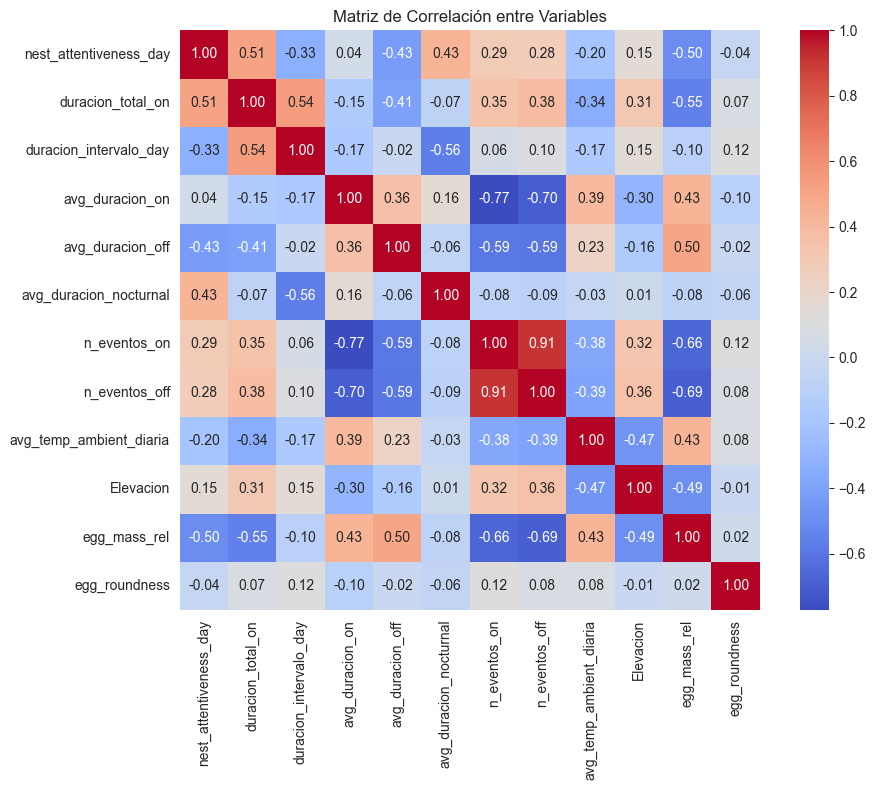

In [69]:
columnas_interes = [
'nest_attentiveness_day', 'duracion_total_on', 'duracion_intervalo_day', 'avg_duracion_on', 'avg_duracion_off', 'avg_duracion_nocturnal', 'n_eventos_on', 'n_eventos_off', 'avg_temp_ambient_diaria', 'Elevacion', 'egg_mass_rel', 'egg_roundness'
]

# Eliminar filas con valores nulos en las columnas de interés
df_corr = resumen_copy[columnas_interes].dropna()

# Calcular matriz de correlación
corr_matrix = df_corr.corr()

# Visualizar con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de Correlación entre Variables')
plt.tight_layout()
plt.show()

In [70]:
estadisticas_altura = resumen_copy.groupby('sp')['nest_attentiveness_day'].agg(
    avg_attentiveness='mean',
    SD_attentiveness='std',
    N='count'
).reset_index()

print(estadisticas_altura)

                  sp  avg_attentiveness  SD_attentiveness    N
0  Isleria hauxwelli           0.367097          0.194720   19
1  Tangara schrankii           0.552718          0.197107  135
2   Turdus hauxwelli           0.713506          0.135919   44


In [71]:
estadisticas_altura = resumen_copy.groupby('sp')['Elevacion'].agg(
    AVG_Elevation='mean',
    SD_Elevation='std',
    N='count'
).reset_index()

print(estadisticas_altura)

                  sp  AVG_Elevation  SD_Elevation    N
0  Isleria hauxwelli     396.210526      8.991224   19
1  Tangara schrankii     535.385185    225.318083  135
2   Turdus hauxwelli     938.704545    414.700653   44


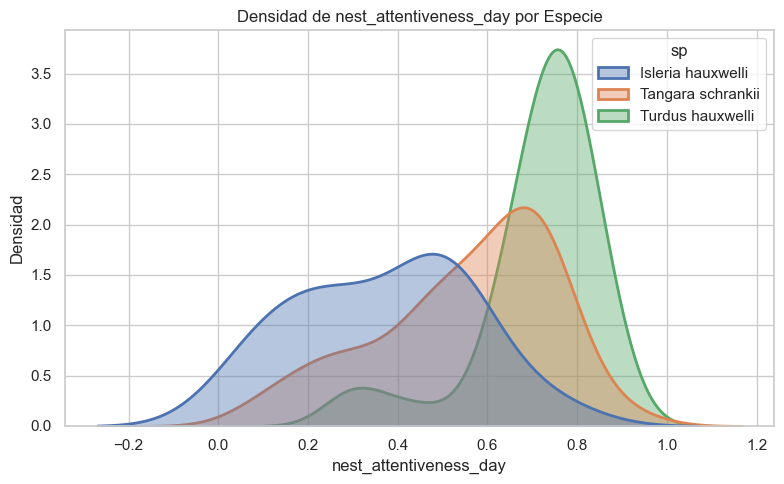

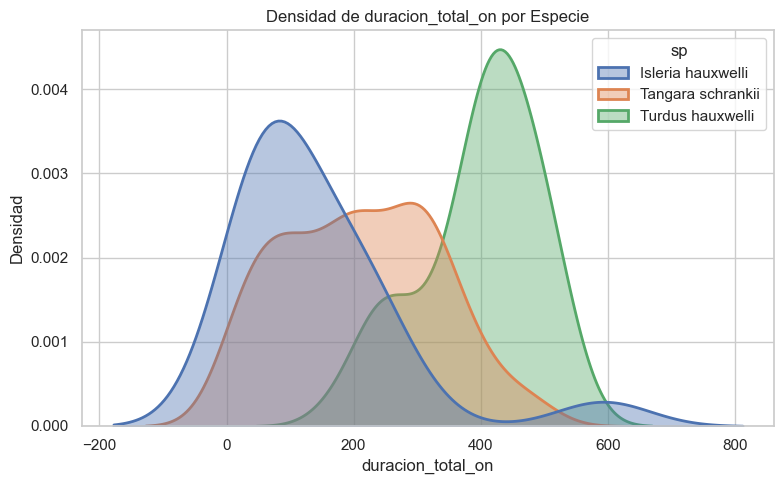

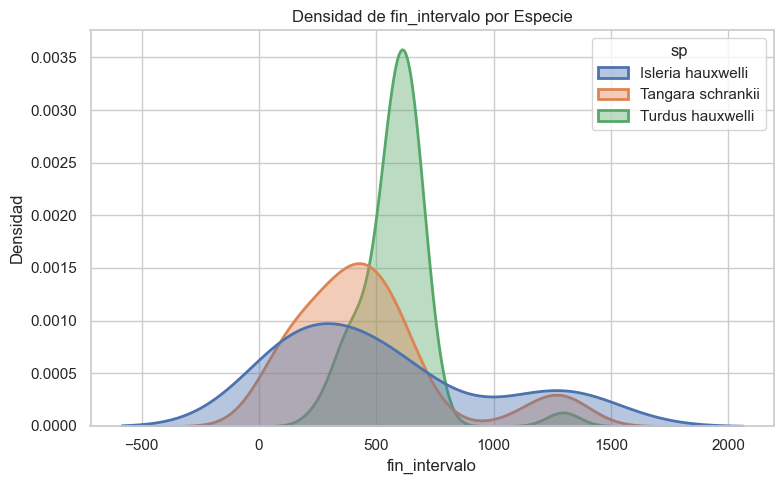

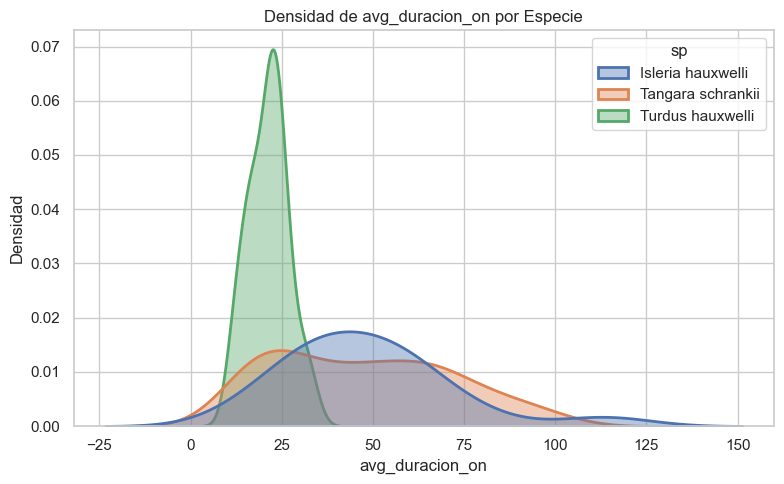

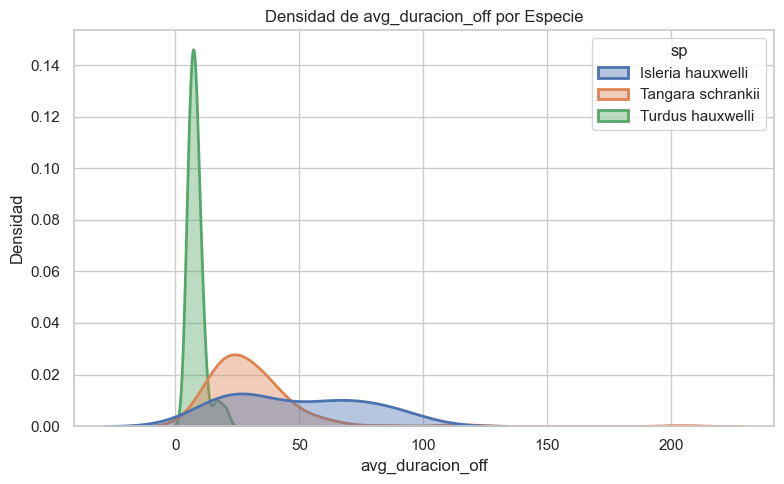

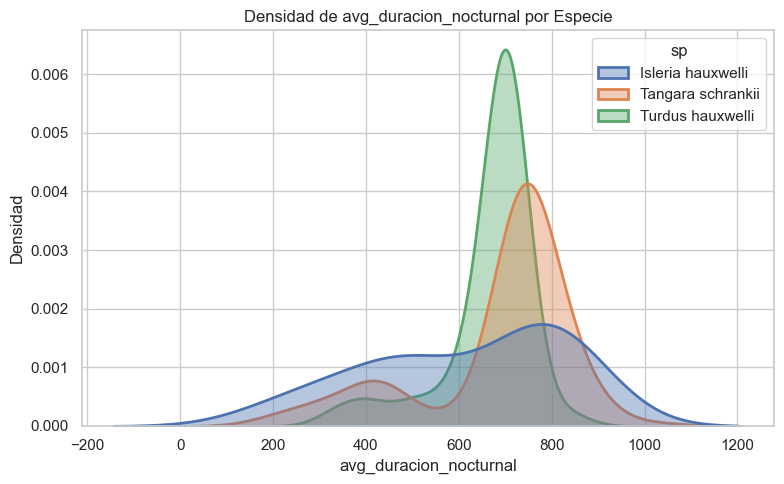

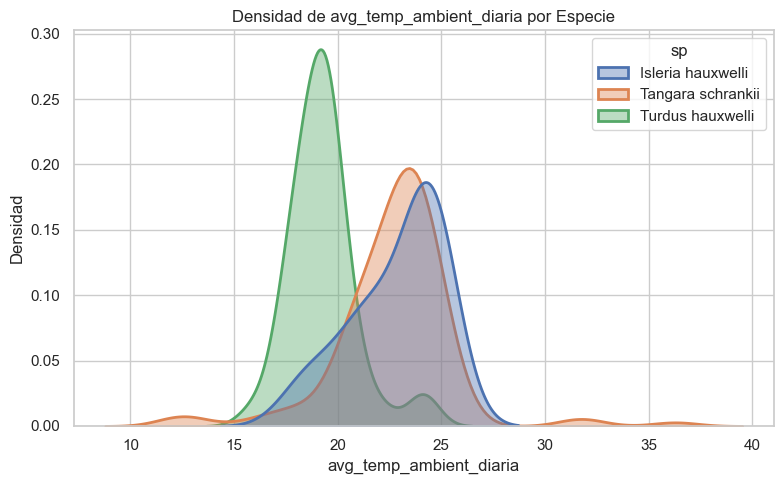

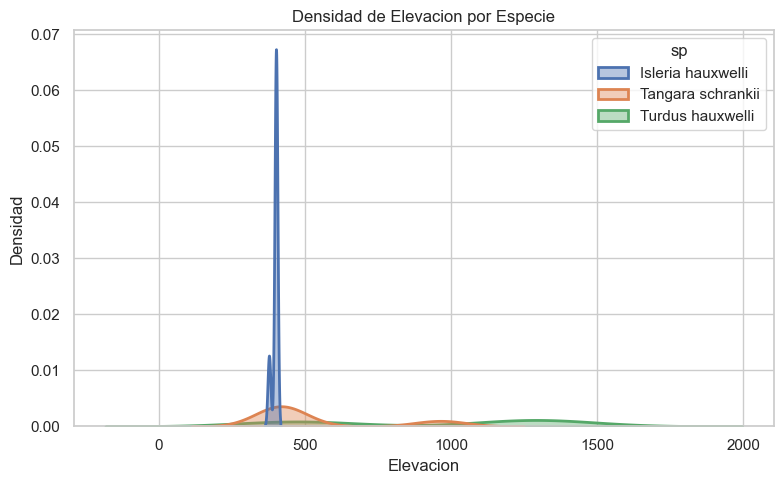

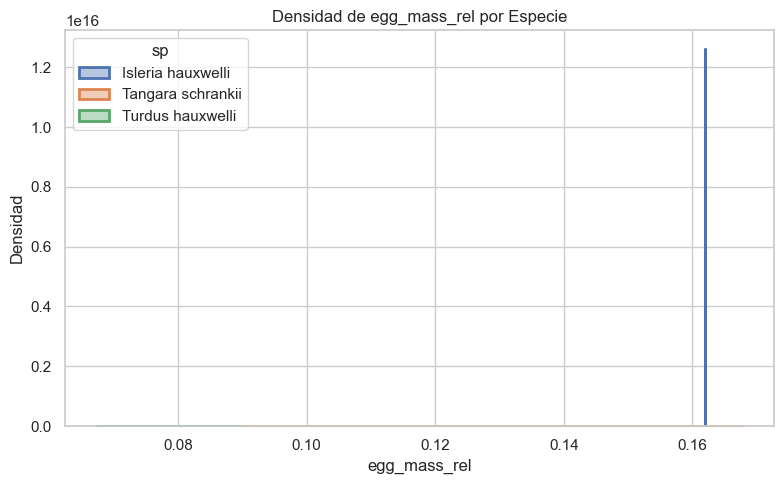

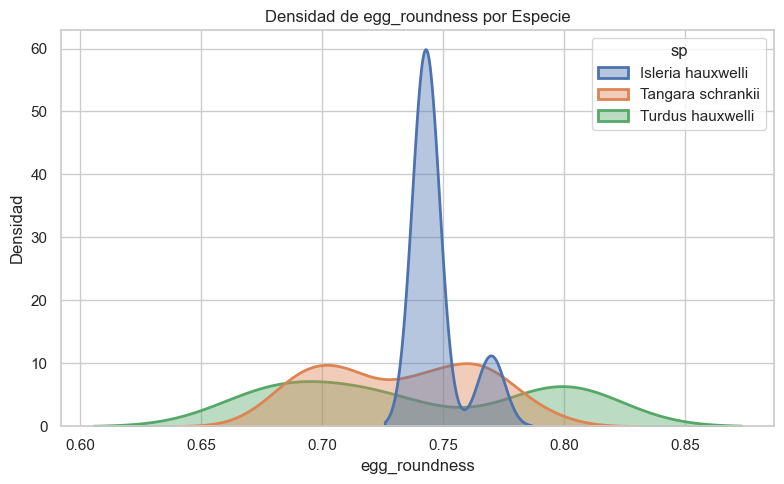

In [72]:
# Variables numéricas a graficar
variables = [
   'nest_attentiveness_day', 'duracion_total_on', 'fin_intervalo', 'avg_duracion_on', 'avg_duracion_off', 'avg_duracion_nocturnal',  'avg_temp_ambient_diaria',
    'Elevacion', 'egg_mass_rel', 'egg_roundness'
]

# Ajustes generales
sns.set(style="whitegrid")

# Crear una curva de densidad por variable
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(
        data=resumen_copy,
        x=var,
        hue='sp',
        fill=True,  # Rellenar debajo de la curva
        common_norm=False,  # Normalización separada por especie
        alpha=0.4,  # Transparencia
        linewidth=2
    )
    plt.title(f'Densidad de {var} por Especie')
    plt.xlabel(var)
    plt.ylabel('Densidad')
    plt.tight_layout()
    plt.show()

## PCA - Kmeans Clusttering


In [73]:
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [74]:
columnas_a_revisar = ['nest_attentiveness_day', 'duracion_total_on', 'avg_duracion_on', 'avg_duracion_off', 'avg_duracion_nocturnal', 'avg_temp_ambient_diaria', 'Elevacion', 'egg_mass_rel', 'egg_roundness']

# Filtrar filas con al menos un NaN en las columnas especificadas
nas_en_columnas = resumen_copy[resumen_copy[columnas_a_revisar].isna().any(axis=1)]

# Mostrar las filas con el ID correspondiente
resultado = nas_en_columnas[['nido_id'] + columnas_a_revisar]
print(resultado)

Empty DataFrame
Columns: [nido_id, nest_attentiveness_day, duracion_total_on, avg_duracion_on, avg_duracion_off, avg_duracion_nocturnal, avg_temp_ambient_diaria, Elevacion, egg_mass_rel, egg_roundness]
Index: []


In [75]:
columnas_pca = [
    'nest_attentiveness_day', 'duracion_total_on', 'avg_duracion_on', 'avg_duracion_off', 'avg_duracion_nocturnal', 'avg_temp_ambient_diaria', 'Elevacion', 'egg_mass_rel', 'egg_roundness'
]

In [76]:
df_pca = resumen_copy[columnas_pca].dropna()
X_scaled = StandardScaler().fit_transform(df_pca)

In [77]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [78]:
var_exp = pca.explained_variance_ratio_
var_cumsum = np.cumsum(var_exp)

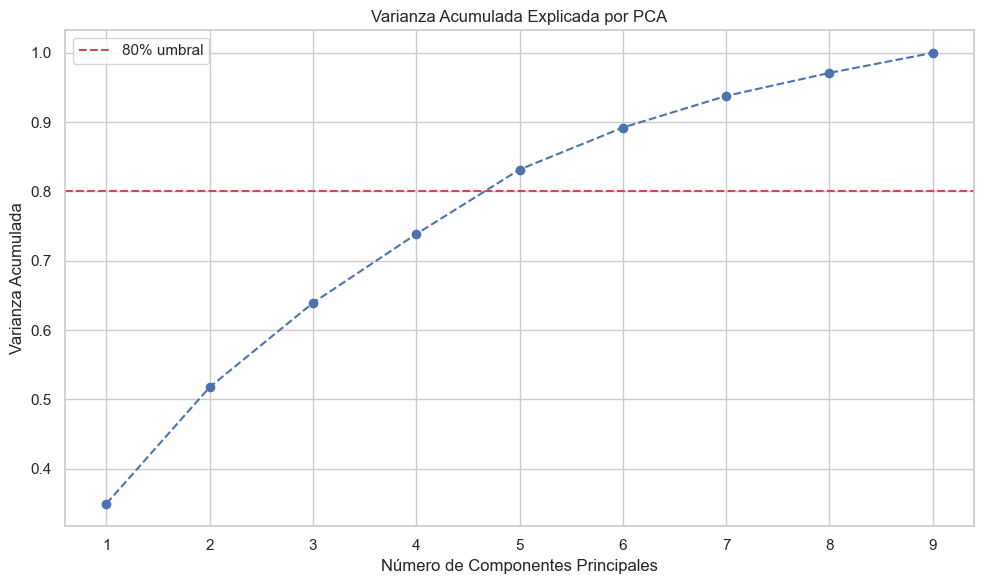

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(var_exp) + 1), var_cumsum, marker='o', linestyle='--')
plt.title('Varianza Acumulada Explicada por PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.axhline(0.80, color='r', linestyle='--', label='80% umbral')
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
df_pca = resumen_copy.dropna(subset=columnas_pca + ['sp']).copy()

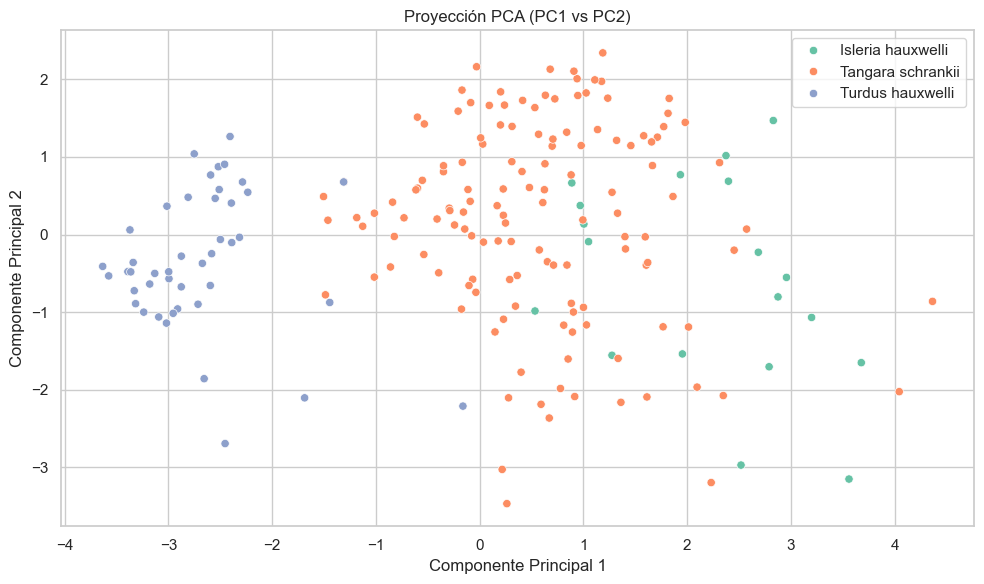

In [81]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# 4. Construir un nuevo DataFrame con los resultados
df_pca_resultado = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'])
df_pca_resultado['sp'] = df_pca['sp'].values

# 5. Visualizar PC1 vs PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca_resultado, x='PC1', y='PC2', hue='sp', palette='Set2')
plt.title('Proyección PCA (PC1 vs PC2)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.tight_layout()
plt.show()

In [82]:
pca_final = PCA(n_components=4)
X_pca_final = pca_final.fit_transform(X_scaled)

In [83]:
features = columnas_pca  # Tu lista original de variables usadas en el PCA

loadings = pd.DataFrame(
    pca.components_[:4].T,  # Solo las 3 primeras componentes
    columns=['PC1', 'PC2', 'PC3', 'PC4'],
    index=features
)

print(loadings)

                              PC1       PC2       PC3       PC4
nest_attentiveness_day  -0.349599  0.541304  0.106040 -0.032116
duracion_total_on       -0.403880  0.079508  0.248943 -0.278860
avg_duracion_on          0.290480  0.472899 -0.037755 -0.108524
avg_duracion_off         0.375356 -0.086045 -0.287310  0.300611
avg_duracion_nocturnal  -0.070185  0.592585 -0.216299  0.544953
avg_temp_ambient_diaria  0.362962  0.211591  0.367599 -0.195218
Elevacion               -0.341963 -0.228423 -0.329719  0.330567
egg_mass_rel             0.485572  0.005424 -0.006757  0.037766
egg_roundness           -0.002222 -0.146616  0.743058  0.610964


In [84]:
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.2%} d varianze")

PC1: 34.94% d varianze
PC2: 16.82% d varianze
PC3: 12.16% d varianze
PC4: 9.93% d varianze


In [85]:
range_n_clusters = range(2, 11)
n_iter = 30 # número de random_state diferentes para promediar
silhouette_avg = []
inertia_avg = []

In [86]:
for k in range_n_clusters:
    silhouette_k = []
    inertia_k = []

    for seed in range(n_iter):
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init=30)
        labels = kmeans.fit_predict(X_pca)
        silhouette_k.append(silhouette_score(X_pca, labels))
        inertia_k.append(kmeans.inertia_)

    silhouette_avg.append(np.mean(silhouette_k))
    inertia_avg.append(np.mean(inertia_k))

Text(0.5, 1.0, 'Método del Codo')

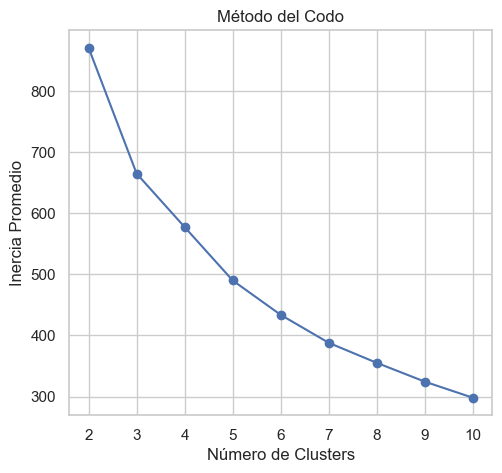

In [87]:
# Plot resultados
plt.figure(figsize=(12, 5))

# Elbow (Inertia)
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia_avg, marker='o')
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia Promedio")
plt.title("Método del Codo")

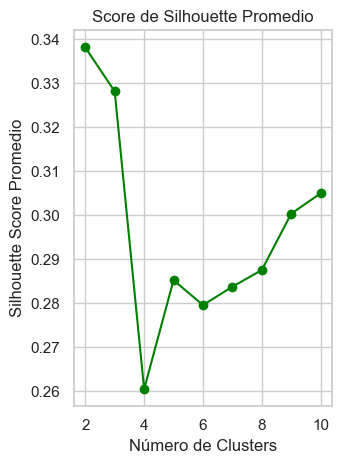

In [88]:
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_avg, marker='o', color='green')
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score Promedio")
plt.title("Score de Silhouette Promedio")

plt.tight_layout()
plt.show()

In [89]:
# Elegir mejor número de clusters según mayor silhouette
best_k = range_n_clusters[np.argmax(silhouette_avg)]
print(f"✅ Mejor número de clusters (basado en silhouette): {best_k}")

✅ Mejor número de clusters (basado en silhouette): 2


In [90]:
# Entrenar KMeans definitivo con ese k y múltiples inicializaciones
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=50)
labels_final = kmeans_final.fit_predict(X_pca)

# Resultado en DataFrame
df_pca_resultado = pd.DataFrame(X_pca[:, :4], columns=['PC1', 'PC2', 'PC3', 'PC4'])
df_pca_resultado['cluster'] = labels_final
df_pca_resultado['sp'] = resumen_copy['sp'].values  # si el índice está alineado

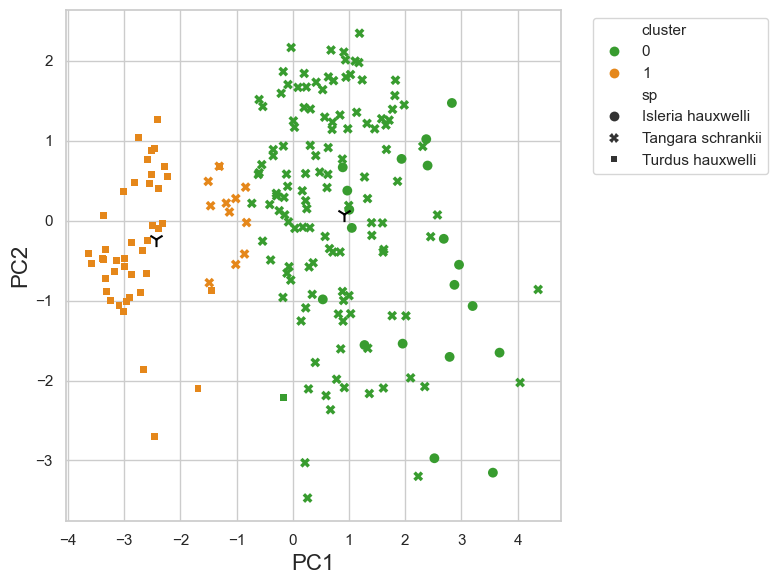

In [91]:
cluster_palette = {0: "#389C2F", 1: "#E5871A"}

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=df_pca_resultado,
    x='PC1', y='PC2',
    hue='cluster',          # colores = cluster
    style='sp',             # formas = especie
    palette=cluster_palette,
    s=50,
    edgecolor='none',       # sin borde blanco
    linewidth=0
)

# Centroides en negro, sin entrar a la leyenda
centroids = kmeans_final.cluster_centers_
ax.scatter(
    centroids[:, 0], centroids[:, 1],
    c='black', marker='1', s=120,
    label='_nolegend_'      # 👈 evita duplicados en la leyenda
)

plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.title('')

# Deja la leyenda automática de seaborn (una sola, con cluster y sp)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

plt.grid(True)
plt.tight_layout()
plt.savefig("G:/Thesis/figures/tanagra_graphs/kmeans_tangara.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [92]:
# Asignar los clústeres al DataFrame original
resumen_copy['cluster'] = labels_final  # Asumiendo....

# columna 'Especie'
df_cluster_analisis = resumen_copy[['cluster', 'sp']].dropna()

In [93]:
tabla = pd.crosstab(df_pca_resultado['cluster'], df_pca_resultado['sp'])
print(tabla)

sp       Isleria hauxwelli  Tangara schrankii  Turdus hauxwelli
cluster                                                        
0                       19                124                 1
1                        0                 11                43


In [94]:
proporcion = tabla.div(tabla.sum(axis=1), axis=0)
print(proporcion.round(2))

sp       Isleria hauxwelli  Tangara schrankii  Turdus hauxwelli
cluster                                                        
0                     0.13               0.86              0.01
1                     0.00               0.20              0.80


In [95]:
from scipy.stats import chi2_contingency

# tu tabla de contingencia
contingency = pd.DataFrame({
    'Isleria hauxwelli': [19,0],
    'Tangara schrankii': [124,11],
    'Turdus hauxwelli': [1,43]
}, index=['Cluster 0','Cluster 1'])

chi2, p, dof, expected = chi2_contingency(contingency)

n = contingency.to_numpy().sum()
min_dim = min(contingency.shape)-1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("Chi² =", chi2)
print("p-value =", p)
print("Cramer's V =", cramers_v)

Chi² = 142.13341049382717
p-value = 1.3681132979390216e-31
Cramer's V = 0.8472576394135267


In [96]:
order_sp = ["Isleria hauxwelli", "Tangara schrankii", "Turdus hauxwelli"]  # opcional
cont = pd.crosstab(resumen_copy["cluster"], resumen_copy["sp"])
cont = cont.reindex(columns=order_sp, fill_value=0)  # asegura orden de columnas


In [97]:

chi2, p, dof, expected = chi2_contingency(cont.values)
expected = pd.DataFrame(expected, index=cont.index, columns=cont.columns)
std_resid = (cont - expected) / np.sqrt(expected)

print("\n=== Standardised residuals (wide) ===")
print(std_resid.round(2))

resid_long = (
    std_resid.stack()
    .rename('std_resid')
    .reset_index()
    .rename(columns={'cluster': 'Cluster', 'sp': 'Especie'})
)
resid_long = resid_long.assign(_abs=resid_long['std_resid'].abs()).sort_values('_abs', ascending=False).drop(columns='_abs')

print("\n=== Standardised residuals (long, sorted by |residual|) ===")
print(resid_long.to_string(index=False))

print(f"\nChi² = {chi2:.3f} | p-value = {p:.3e}")


=== Standardised residuals (wide) ===
sp       Isleria hauxwelli  Tangara schrankii  Turdus hauxwelli
cluster                                                        
0                     1.39               2.61             -5.48
1                    -2.28              -4.25              8.95

=== Standardised residuals (long, sorted by |residual|) ===
 Cluster           Especie  std_resid
       1  Turdus hauxwelli   8.948929
       0  Turdus hauxwelli  -5.480078
       1 Tangara schrankii  -4.254950
       0 Tangara schrankii   2.605614
       1 Isleria hauxwelli  -2.276361
       0 Isleria hauxwelli   1.393981

Chi² = 142.133 | p-value = 1.368e-31


In [98]:
resumen_copy['cluster'] = labels_final

In [99]:
resumen_copy = resumen_copy.reset_index(drop=True)
df_pca_resultado = df_pca_resultado.reset_index(drop=True)

resumen_copy['cluster'] = df_pca_resultado['cluster']

In [100]:
resumen_clusters = resumen_copy.groupby('cluster')[columnas_pca].mean().round(2).T
print(resumen_clusters)

cluster                       0       1
nest_attentiveness_day     0.52    0.72
duracion_total_on        198.57  370.22
avg_duracion_on           48.27   23.85
avg_duracion_off          34.15   10.58
avg_duracion_nocturnal   667.95  686.77
avg_temp_ambient_diaria   23.13   18.84
Elevacion                495.69  920.89
egg_mass_rel               0.13    0.09
egg_roundness              0.74    0.73


In [101]:
resumen_media = resumen_copy.groupby('cluster')[columnas_pca].mean().round(2).T
resumen_std = resumen_copy.groupby('cluster')[columnas_pca].std().round(2).T

# Unir ambas tablas
resumen_detallado = resumen_media.copy()
for c in resumen_media.columns:
    resumen_detallado[c] = resumen_media[c].astype(str) + " ± " + resumen_std[c].astype(str)

resumen_detallado.columns = [f"Cluster {c}" for c in resumen_detallado.columns]
print(resumen_detallado)

                               Cluster 0        Cluster 1
nest_attentiveness_day       0.52 ± 0.21      0.72 ± 0.12
duracion_total_on        198.57 ± 124.96  370.22 ± 111.53
avg_duracion_on            48.27 ± 24.56     23.85 ± 8.79
avg_duracion_off           34.15 ± 23.94     10.58 ± 6.14
avg_duracion_nocturnal   667.95 ± 178.06   686.77 ± 81.95
avg_temp_ambient_diaria     23.13 ± 2.31     18.84 ± 2.06
Elevacion                495.69 ± 195.81  920.89 ± 388.27
egg_mass_rel                 0.13 ± 0.02      0.09 ± 0.02
egg_roundness                0.74 ± 0.03      0.73 ± 0.05


# Then to the nutshell

In [102]:
ranking_pca = loadings.abs().sum(axis=1).sort_values(ascending=False)
print("=== Ranking de importancia según PCA ===")
print(ranking_pca)

# 2. Ranking por varianza entre clusters (ANOVA simple)
from sklearn.feature_selection import f_classif

X_sel = resumen_copy[columnas_pca].values
y_sel = resumen_copy['cluster'].values

f_vals, p_vals = f_classif(X_sel, y_sel)
ranking_anova = pd.Series(f_vals, index=columnas_pca).sort_values(ascending=False)

print("\n=== Ranking de importancia según F-test entre clusters ===")
print(ranking_anova)

# 3. Variables top (intersección de ambos criterios)
top_vars = set(ranking_pca.head(6).index) | set(ranking_anova.head(6).index)
print("\nVariables seleccionadas para análisis detallado:")
print(top_vars)

=== Ranking de importancia según PCA ===
egg_roundness              1.502860
avg_duracion_nocturnal     1.424022
Elevacion                  1.230673
avg_temp_ambient_diaria    1.137371
avg_duracion_off           1.049322
nest_attentiveness_day     1.029060
duracion_total_on          1.011191
avg_duracion_on            0.909657
egg_mass_rel               0.535518
dtype: float64

=== Ranking de importancia según F-test entre clusters ===
egg_mass_rel               296.884306
avg_temp_ambient_diaria    142.982685
Elevacion                  103.291588
duracion_total_on           78.421872
avg_duracion_off            50.941375
avg_duracion_on             50.778319
nest_attentiveness_day      45.171308
avg_duracion_nocturnal       0.557629
egg_roundness                0.053228
dtype: float64

Variables seleccionadas para análisis detallado:
{'egg_roundness', 'avg_duracion_off', 'avg_temp_ambient_diaria', 'Elevacion', 'nest_attentiveness_day', 'duracion_total_on', 'avg_duracion_nocturnal', 'a

In [103]:
import scikit_posthocs as sp
from scipy.stats import kruskal

In [104]:
print(resumen_copy.columns)

Index(['archivo', 'dia', 'nest_attentiveness_day', 'duracion_total_on',
       'duracion_intervalo_day', 'inicio_intervalo', 'fin_intervalo',
       'avg_duracion_on', 'avg_duracion_off', 'avg_duracion_nocturnal',
       'n_eventos_on', 'n_eventos_off', 'avg_temp_ambient_diaria', 'especie',
       'nido_id', 'sp', 'sp_old', 'cod_del_nido', 'Elevacion', 'Largo_mm.2',
       'Ancho_mm.2', 'Peso_g', 'egg_mass_rel', 'egg_roundness', 'cluster'],
      dtype='object')


In [105]:

# Supongamos que se llama "Especie"
groups = [resumen_copy.loc[resumen_copy["sp"] == especie, "nest_attentiveness_day"].dropna()
          for especie in resumen_copy["sp"].unique()]

# Kruskal-Wallis
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.3e}")

# Dunn test con corrección de Holm
dunn = sp.posthoc_dunn(resumen_copy, val_col="nest_attentiveness_day",
                       group_col="sp", p_adjust="holm")
print(dunn)

Kruskal-Wallis H = 45.767, p = 1.153e-10
                   Isleria hauxwelli  Tangara schrankii  Turdus hauxwelli
Isleria hauxwelli       1.000000e+00       1.133504e-03      1.313083e-09
Tangara schrankii       1.133504e-03       1.000000e+00      2.683067e-07
Turdus hauxwelli        1.313083e-09       2.683067e-07      1.000000e+00


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5424\1245771345.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


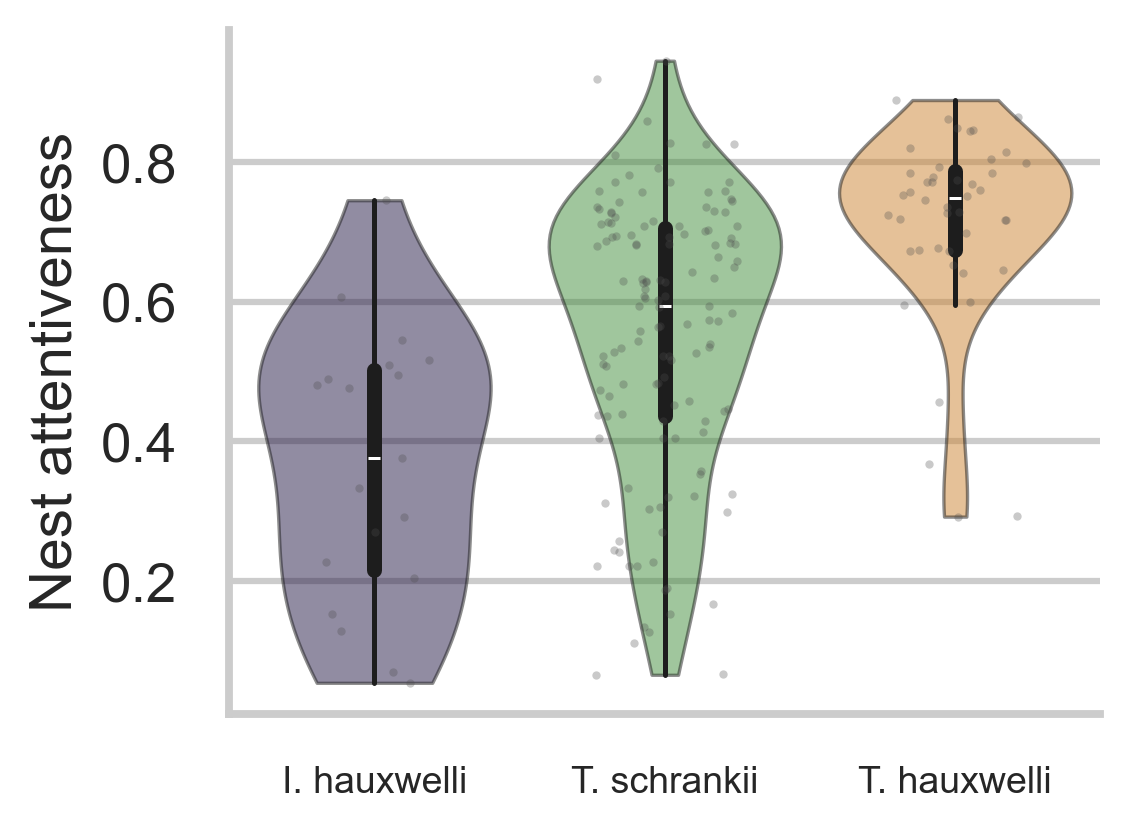

In [106]:

order = ["Isleria hauxwelli", "Tangara schrankii", "Turdus hauxwelli"]

palette = {
    "Isleria hauxwelli": "#21134D",
    "Tangara schrankii": "#389C2F",
    "Turdus hauxwelli": "#E5871A"
}

# Ajuste global de estilo y tamaño de fuentes
sns.set(style="whitegrid", context="talk", font_scale=0.8)

plt.figure(figsize=(4, 3), dpi=300)

# violín con box interno
sns.violinplot(
    data=resumen_copy,
    x="sp",
    y="nest_attentiveness_day",
    order=order,
    palette=palette,
    inner="box",
    cut=0,
    alpha=0.5,
    linewidth=0.8
)

# puntos encima
sns.stripplot(
    data=resumen_copy,
    x="sp",
    y="nest_attentiveness_day",
    order=order,
    color="0.3",
    alpha=0.3,
    jitter=0.25,
    size=2
)

# etiquetas y ejes
plt.ylabel("Nest attentiveness", fontsize=14)
plt.xlabel("")

# abreviar nombres en el eje X
plt.xticks(
    ticks=[0, 1, 2],
    labels=["I. hauxwelli", "T. schrankii", "T. hauxwelli"],
    fontsize=9
)

sns.despine()
plt.tight_layout()
plt.savefig("G:/Thesis/figures/tanagra_graphs/attentiveness_3species.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [107]:
# Verifica primero cómo se llama la columna de especies
#print(resumen_copy.columns)

# Supongamos que se llama "Especie"
groups = [resumen_copy.loc[resumen_copy["sp"] == especie, "duracion_total_on"].dropna()
          for especie in resumen_copy["sp"].unique()]

# Kruskal-Wallis
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.3e}")

# Dunn test con corrección de Holm
dunn = sp.posthoc_dunn(resumen_copy, val_col="duracion_total_on",
                       group_col="sp", p_adjust="holm")
print(dunn)

Kruskal-Wallis H = 67.015, p = 2.805e-15
                   Isleria hauxwelli  Tangara schrankii  Turdus hauxwelli
Isleria hauxwelli       1.000000e+00       2.230005e-02      4.680812e-11
Tangara schrankii       2.230005e-02       1.000000e+00      6.277063e-13
Turdus hauxwelli        4.680812e-11       6.277063e-13      1.000000e+00


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5424\3175634949.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


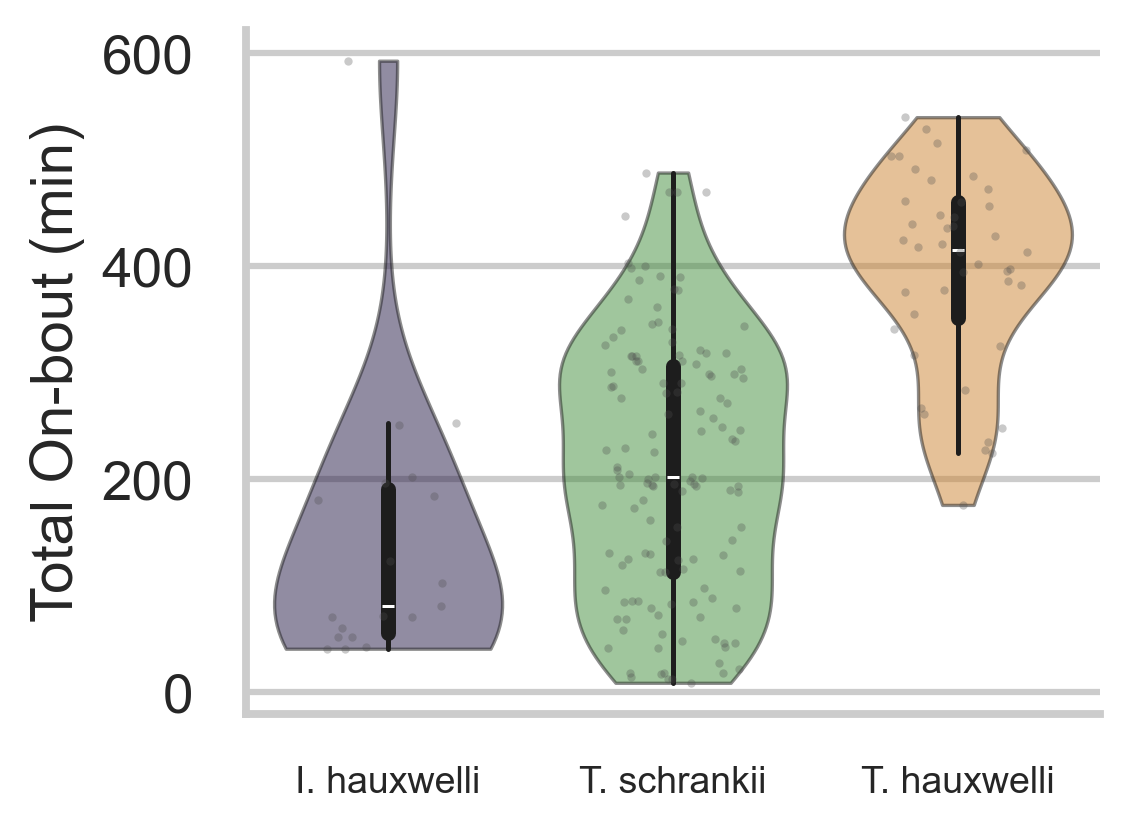

In [108]:

order = ["Isleria hauxwelli", "Tangara schrankii", "Turdus hauxwelli"]

palette = {
    "Isleria hauxwelli": "#21134D",
    "Tangara schrankii": "#389C2F",
    "Turdus hauxwelli": "#E5871A"
}

# Ajuste global de estilo y tamaño de fuentes
sns.set(style="whitegrid", context="talk", font_scale=0.8)

plt.figure(figsize=(4, 3), dpi=300)

# violín con box interno
sns.violinplot(
    data=resumen_copy,
    x="sp",
    y="duracion_total_on",
    order=order,
    palette=palette,
    inner="box",
    cut=0,
    alpha=0.5,
    linewidth=0.8
)

# puntos encima
sns.stripplot(
    data=resumen_copy,
    x="sp",
    y="duracion_total_on",
    order=order,
    color="0.3",
    alpha=0.3,
    jitter=0.25,
    size=2
)

# etiquetas y ejes
plt.ylabel("Total On-bout (min)", fontsize=14)
plt.xlabel("")

# abreviar nombres en el eje X
plt.xticks(
    ticks=[0, 1, 2],
    labels=["I. hauxwelli", "T. schrankii", "T. hauxwelli"],
    fontsize=9
)

sns.despine()
plt.tight_layout()
plt.savefig("G:/Thesis/figures/tanagra_graphs/totalOn_3species.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [109]:
groups = [resumen_copy.loc[resumen_copy["sp"] == especie, "avg_duracion_on"].dropna()
          for especie in resumen_copy["sp"].unique()]

# Kruskal-Wallis
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.3e}")

# Dunn test con corrección de Holm
dunn = sp.posthoc_dunn(resumen_copy, val_col="avg_duracion_on",
                       group_col="sp", p_adjust="holm")
print(dunn)

Kruskal-Wallis H = 45.304, p = 1.453e-10
                   Isleria hauxwelli  Tangara schrankii  Turdus hauxwelli
Isleria hauxwelli           1.000000       6.793774e-01      1.316375e-05
Tangara schrankii           0.679377       1.000000e+00      1.802886e-10
Turdus hauxwelli            0.000013       1.802886e-10      1.000000e+00


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5424\530488763.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


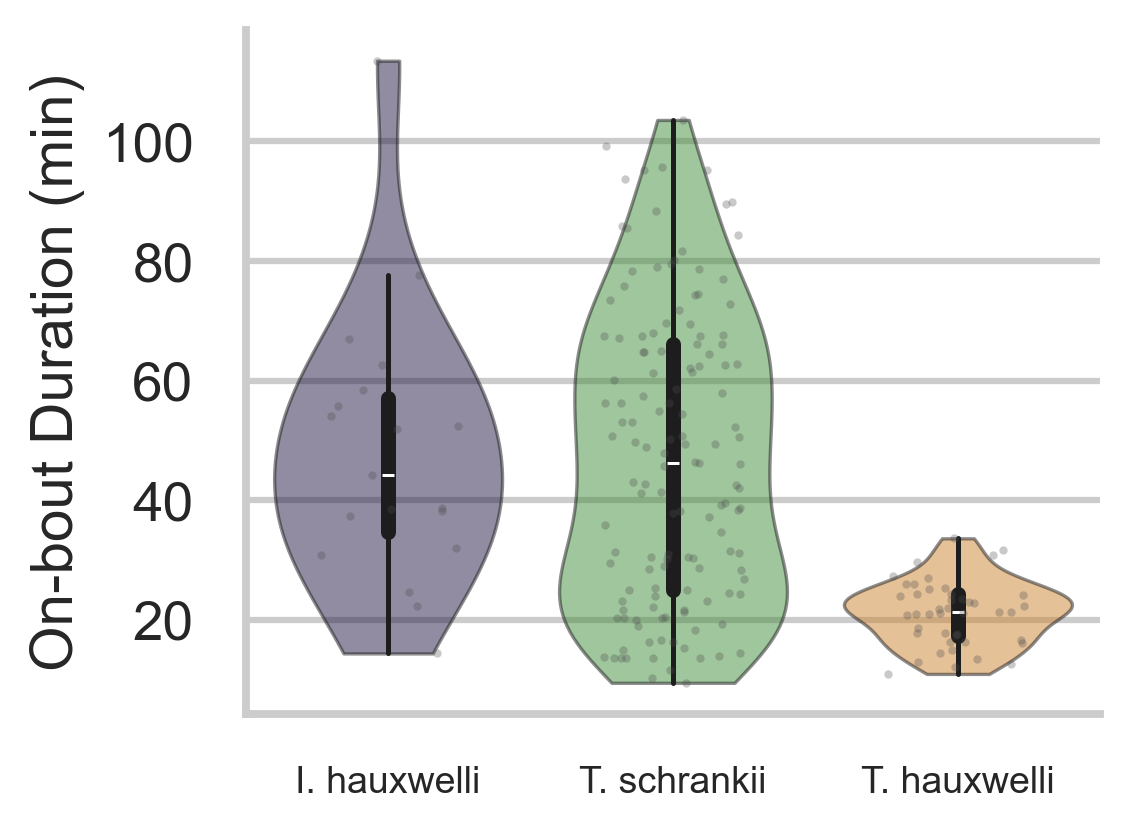

In [110]:
order = ["Isleria hauxwelli", "Tangara schrankii", "Turdus hauxwelli"]

palette = {
    "Isleria hauxwelli": "#21134D",
    "Tangara schrankii": "#389C2F",
    "Turdus hauxwelli": "#E5871A"
}

# Ajuste global de estilo y tamaño de fuentes
sns.set(style="whitegrid", context="talk", font_scale=0.8)

plt.figure(figsize=(4, 3), dpi=300)

# violín con box interno
sns.violinplot(
    data=resumen_copy,
    x="sp",
    y="avg_duracion_on",
    order=order,
    palette=palette,
    inner="box",
    cut=0,
    alpha=0.5,
    linewidth=0.8
)

# puntos encima
sns.stripplot(
    data=resumen_copy,
    x="sp",
    y="avg_duracion_on",
    order=order,
    color="0.3",
    alpha=0.3,
    jitter=0.25,
    size=2
)

# etiquetas y ejes
plt.ylabel("On-bout Duration (min)", fontsize=14)
plt.xlabel("")

# abreviar nombres en el eje X
plt.xticks(
    ticks=[0, 1, 2],
    labels=["I. hauxwelli", "T. schrankii", "T. hauxwelli"],
    fontsize=9
)

sns.despine()
plt.tight_layout()
plt.savefig("G:/Thesis/figures/tanagra_graphs/On-Bout_3species.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [111]:
groups = [resumen_copy.loc[resumen_copy["sp"] == especie, "egg_mass_rel"].dropna()
          for especie in resumen_copy["sp"].unique()]

# Kruskal-Wallis
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.3e}")

# Dunn test con corrección de Holm
dunn = sp.posthoc_dunn(resumen_copy, val_col="egg_mass_rel",
                       group_col="sp", p_adjust="holm")
print(dunn)

Kruskal-Wallis H = 132.726, p = 1.510e-29
                   Isleria hauxwelli  Tangara schrankii  Turdus hauxwelli
Isleria hauxwelli       1.000000e+00       3.918983e-08      8.501118e-26
Tangara schrankii       3.918983e-08       1.000000e+00      3.955858e-19
Turdus hauxwelli        8.501118e-26       3.955858e-19      1.000000e+00


In [112]:
print(resumen_copy.columns)

Index(['archivo', 'dia', 'nest_attentiveness_day', 'duracion_total_on',
       'duracion_intervalo_day', 'inicio_intervalo', 'fin_intervalo',
       'avg_duracion_on', 'avg_duracion_off', 'avg_duracion_nocturnal',
       'n_eventos_on', 'n_eventos_off', 'avg_temp_ambient_diaria', 'especie',
       'nido_id', 'sp', 'sp_old', 'cod_del_nido', 'Elevacion', 'Largo_mm.2',
       'Ancho_mm.2', 'Peso_g', 'egg_mass_rel', 'egg_roundness', 'cluster'],
      dtype='object')


In [113]:
# Supongamos que se llama "Especie"
groups = [resumen_copy.loc[resumen_copy["sp"] == especie, "avg_duracion_off"].dropna()
          for especie in resumen_copy["sp"].unique()]

# Kruskal-Wallis
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.3e}")

# Dunn test con corrección de Holm
dunn = sp.posthoc_dunn(resumen_copy, val_col="avg_duracion_off",
                       group_col="sp", p_adjust="holm")
print(dunn)

Kruskal-Wallis H = 101.259, p = 1.028e-22
                   Isleria hauxwelli  Tangara schrankii  Turdus hauxwelli
Isleria hauxwelli       1.000000e+00       2.383539e-02      6.857537e-15
Tangara schrankii       2.383539e-02       1.000000e+00      5.997902e-20
Turdus hauxwelli        6.857537e-15       5.997902e-20      1.000000e+00


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5424\2373819329.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


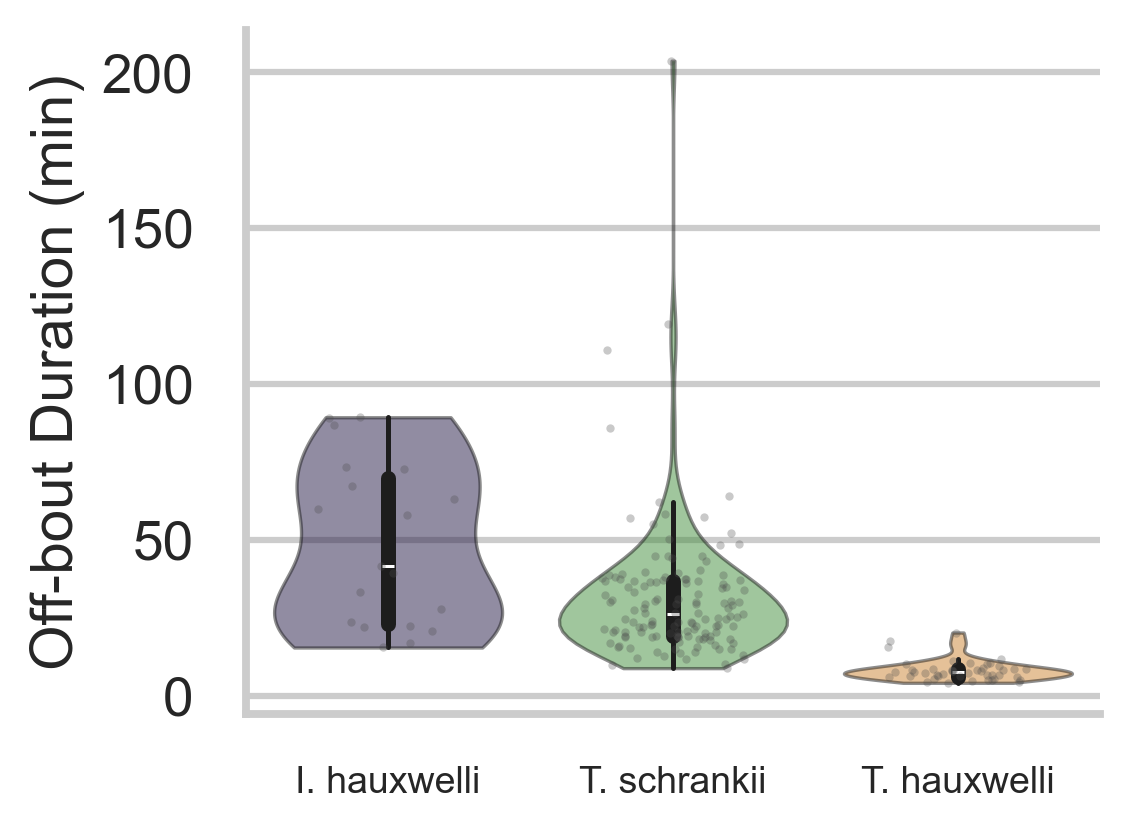

In [114]:
order = ["Isleria hauxwelli", "Tangara schrankii", "Turdus hauxwelli"]

palette = {
    "Isleria hauxwelli": "#21134D",
    "Tangara schrankii": "#389C2F",
    "Turdus hauxwelli": "#E5871A"
}

# Ajuste global de estilo y tamaño de fuentes
sns.set(style="whitegrid", context="talk", font_scale=0.8)

plt.figure(figsize=(4, 3), dpi=300)

# violín con box interno
sns.violinplot(
    data=resumen_copy,
    x="sp",
    y="avg_duracion_off",
    order=order,
    palette=palette,
    inner="box",
    cut=0,
    alpha=0.5,
    linewidth=0.8
)

# puntos encima
sns.stripplot(
    data=resumen_copy,
    x="sp",
    y="avg_duracion_off",
    order=order,
    color="0.3",
    alpha=0.3,
    jitter=0.25,
    size=2
)

# etiquetas y ejes
plt.ylabel("Off-bout Duration (min)", fontsize=14)
plt.xlabel("")

# abreviar nombres en el eje X
plt.xticks(
    ticks=[0, 1, 2],
    labels=["I. hauxwelli", "T. schrankii", "T. hauxwelli"],
    fontsize=9
)

sns.despine()
plt.tight_layout()
plt.savefig("G:/Thesis/figures/tanagra_graphs/Off-Bout_3species.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [115]:
#columnas_pca = [
#    'nest_attentiveness_day', 'duracion_total_on', 'avg_duracion_on', 'avg_duracion_off', 'avg_duracion_nocturnal', 'avg_temp_ambient_diaria', 'Elevacion', 'egg_mass_rel', 'egg_roundness'
#]

In [116]:
groups = [resumen_copy.loc[resumen_copy["sp"] == especie, "avg_duracion_nocturnal"].dropna()
          for especie in resumen_copy["sp"].unique()]

# Kruskal-Wallis
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.3e}")

# Dunn test con corrección de Holm
dunn = sp.posthoc_dunn(resumen_copy, val_col="avg_duracion_nocturnal",
                       group_col="sp", p_adjust="holm")
print(dunn)

Kruskal-Wallis H = 18.273, p = 1.076e-04
                   Isleria hauxwelli  Tangara schrankii  Turdus hauxwelli
Isleria hauxwelli           1.000000           0.291221          0.158991
Tangara schrankii           0.291221           1.000000          0.000061
Turdus hauxwelli            0.158991           0.000061          1.000000


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13400\607617979.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


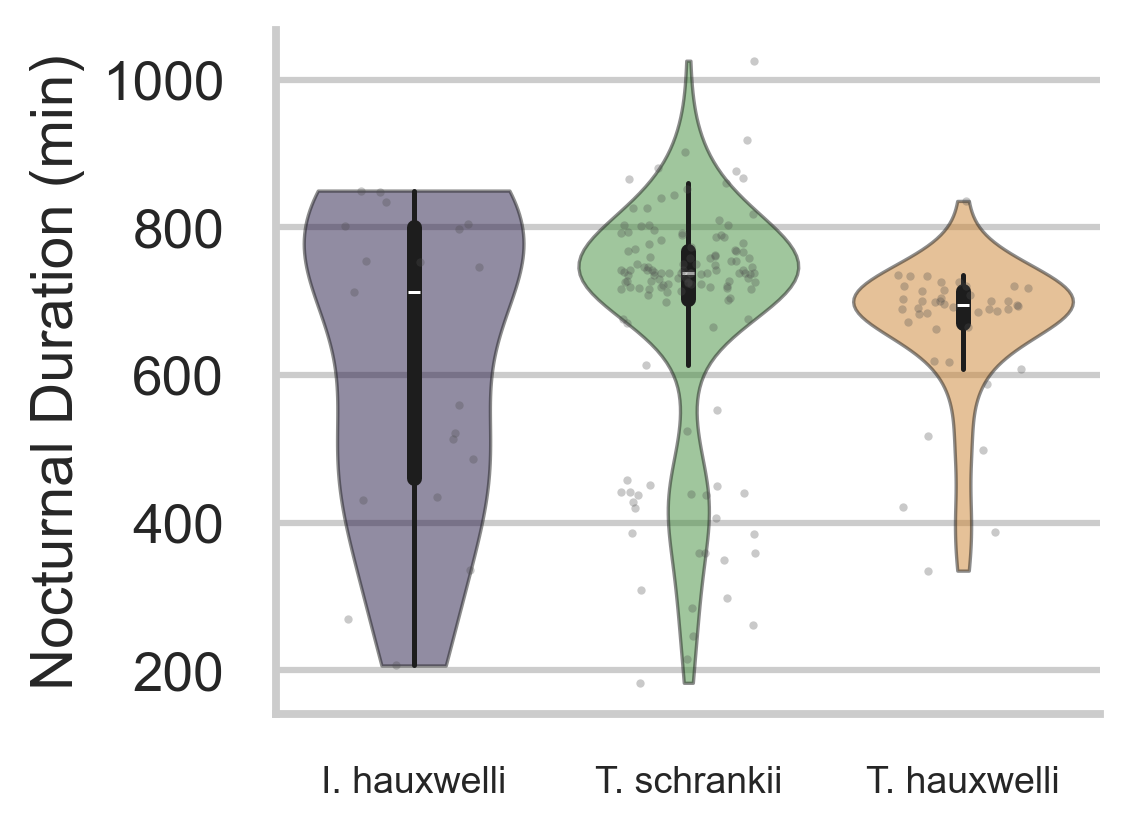

In [117]:
order = ["Isleria hauxwelli", "Tangara schrankii", "Turdus hauxwelli"]

palette = {
    "Isleria hauxwelli": "#21134D",
    "Tangara schrankii": "#389C2F",
    "Turdus hauxwelli": "#E5871A"
}

# Ajuste global de estilo y tamaño de fuentes
sns.set(style="whitegrid", context="talk", font_scale=0.8)

plt.figure(figsize=(4, 3), dpi=300)

# violín con box interno
sns.violinplot(
    data=resumen_copy,
    x="sp",
    y="avg_duracion_nocturnal",
    order=order,
    palette=palette,
    inner="box",
    cut=0,
    alpha=0.5,
    linewidth=0.8
)

# puntos encima
sns.stripplot(
    data=resumen_copy,
    x="sp",
    y="avg_duracion_nocturnal",
    order=order,
    color="0.3",
    alpha=0.3,
    jitter=0.25,
    size=2
)

# etiquetas y ejes
plt.ylabel("Nocturnal Duration (min)", fontsize=14)
plt.xlabel("")

# abreviar nombres en el eje X
plt.xticks(
    ticks=[0, 1, 2],
    labels=["I. hauxwelli", "T. schrankii", "T. hauxwelli"],
    fontsize=9
)

sns.despine()
plt.tight_layout()
plt.savefig("G:/Thesis/figures/tanagra_graphs/Nocturnal-Bout_3species.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()